# Baseline Encoder-Decoder transformer experiments

This notebook contains the experiments of the base encoder-decoder transformer applied in the context of timeseries forecasting. The implementation is a baseline without any adjustments to the attention mechanism. In this notebook, you will find the following experiments:
- **Experiment 1**: 1-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 2**: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 3**: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target
- **Experiment 4**: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series
- **Experiment 5**: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target
- **Experiment 6**: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target
- **Experiment 7**: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

For visualization and inspection purposes, we use 3 decoder layers and a single attention head

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import src.Datasets.SyntheticDataset as SD
from src.Transformer.EncoderDecoder import PointEncoderDecoderTransformer
from src.train import train_step_enc_dec, val_step_enc_dec
from src.utils import collate_fn

## Experiment 1: one-step prediction on `SimplePeriodicDataset` with overlapping source and target

### Configs

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model)
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1048               # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 30                             # training epochs

### Dataset splits

In [11]:
dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

# dataset.fX = (dataset.fX - torch.mean(dataset.fX, dim=0, keepdim=True)) / torch.std(dataset.fX, dim=0, keepdim=True)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

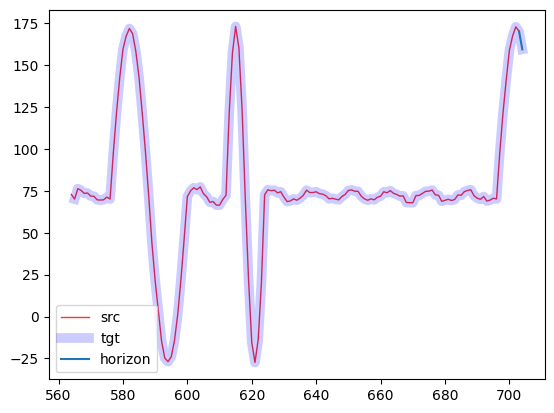

In [12]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [13]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

# criterion = nn.SmoothL1Loss() 
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)
# scheduler = get_linear_schedule_with_warmup(optimizer, EPOCHS//4, EPOCHS)

### Training

In [19]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, 0, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, 0, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=53.0088	val_loss=496.0648	R_p=['0.1409', '0.0952']
epoch=1	train_loss=51.6459	val_loss=476.3606	R_p=['0.1360', '0.0835']
epoch=2	train_loss=50.1545	val_loss=499.7657	R_p=['0.1409', '0.0927']
epoch=3	train_loss=49.6312	val_loss=544.8669	R_p=['0.1436', '0.0853']
epoch=4	train_loss=48.7984	val_loss=538.3461	R_p=['0.1463', '0.0991']
epoch=5	train_loss=47.4469	val_loss=519.0899	R_p=['0.1393', '0.0769']
epoch=6	train_loss=47.1638	val_loss=525.6673	R_p=['0.1399', '0.0831']
epoch=7	train_loss=46.5844	val_loss=503.1717	R_p=['0.1383', '0.0852']
epoch=8	train_loss=46.5661	val_loss=513.9413	R_p=['0.1377', '0.0772']
epoch=9	train_loss=46.2738	val_loss=546.8971	R_p=['0.1412', '0.0814']
epoch=10	train_loss=44.8761	val_loss=517.0339	R_p=['0.1385', '0.0782']
epoch=11	train_loss=44.9922	val_loss=516.2262	R_p=['0.1389', '0.0824']
epoch=12	train_loss=43.3347	val_loss=506.2432	R_p=['0.1404', '0.0951']
epoch=13	train_loss=43.1344	val_loss=508.4777	R_p=['0.1393', '0.0902']
epoch=14	train_l

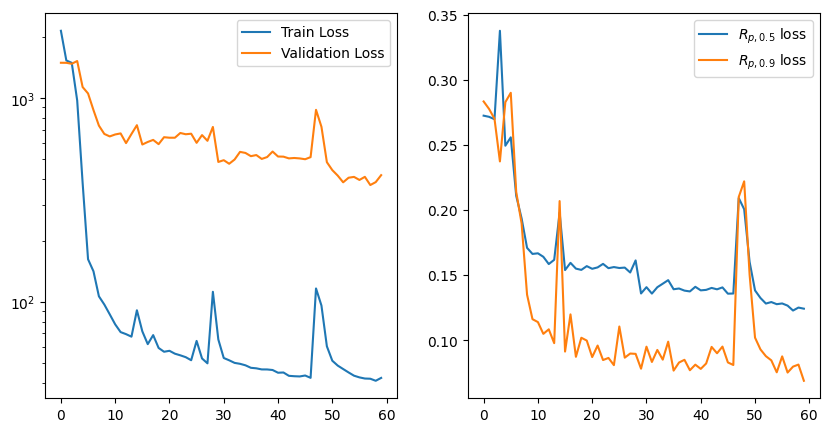

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [21]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, r_ps

(412.69963061523435, tensor([0.1244, 0.0705], device='cuda:0'))

### Predict

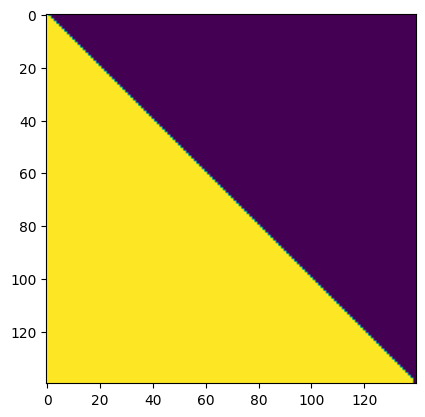

In [22]:
mask = dataset.mask

mask2 = torch.clone(mask)
mask2[:, -shift:] = 0

plt.imshow(mask2.cpu())

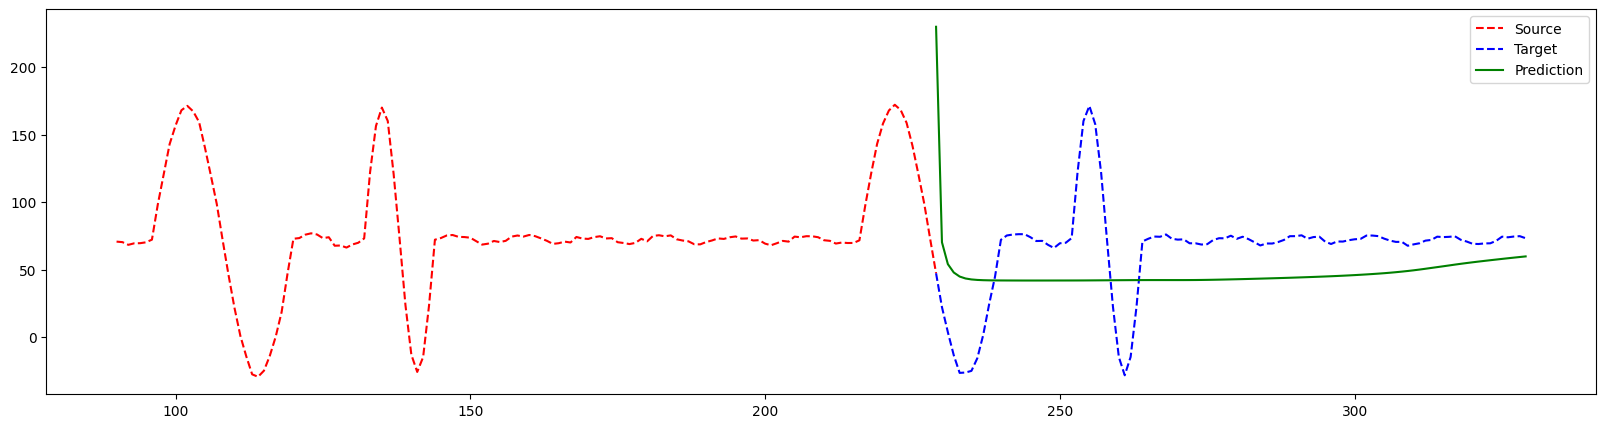

In [23]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    
    sample = dataset[idx]
    src_X, src_fX, tgt_x, tgt_fx = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = tgt_x
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(src_X, src_fX, pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        
        # src_X = torch.cat([src_X, src_X[:, -1:] + 1], dim=1) # extend src X with next time step
        # src_fX = torch.cat([src_fX, pred_fX[:, -1:]], dim=1) # extend source fX with first pred fX
        
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1) # extend pred X with next time step
        pred_fX = torch.cat([pred_fX, out[:, -1:]], dim=1) # extend pred fX with last output step
        
        enc_attention_weights.append(model.enc_attn_weights)
        dec_attention_weights.append(model.dec_attn_weights)
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

src_X = src_X.squeeze().cpu()
src_fX = src_fX.squeeze().cpu()
pred_X = pred_X.squeeze().cpu()
pred_fX = pred_fX.squeeze().cpu()

plt.figure(figsize=(20, 5))
plt.plot(src_X, src_fX, '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
# plt.plot(pred_X[-seq_len:], pred_fX[-seq_len:], '-g', label="Prediction")
plt.plot(pred_X[-horizon-1:], pred_fX[-horizon-1:], '-g', label="Prediction")
plt.legend()

In [24]:
inspect_step = 0

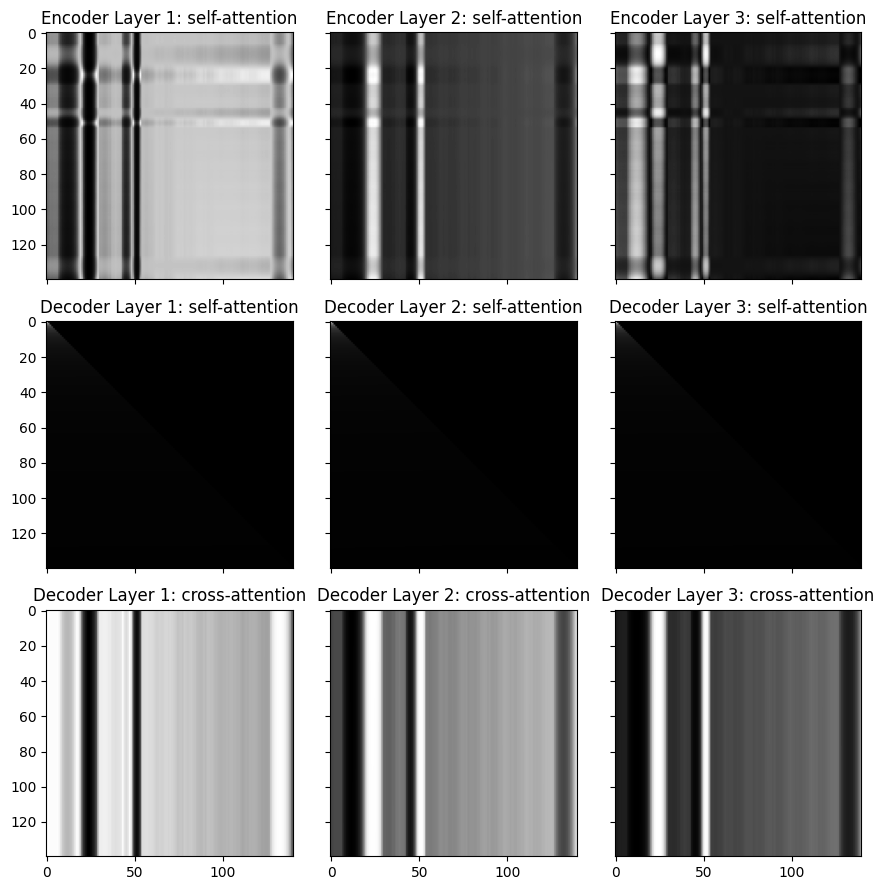

In [25]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, :].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, :].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, :].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

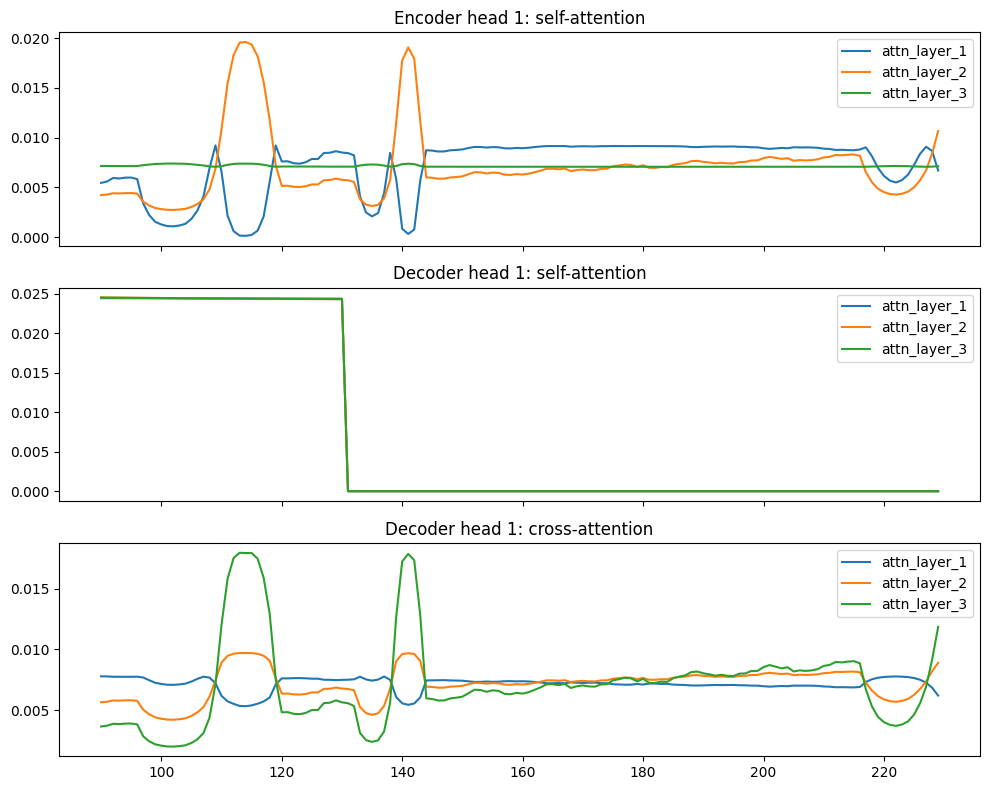

In [26]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -horizon, :].cpu()
        ax.plot(src_X[-seq_len:], attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -horizon, :].cpu()
        ax.plot(src_X[-seq_len:], attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -horizon, :].cpu()
        ax.plot(src_X[-seq_len:], attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

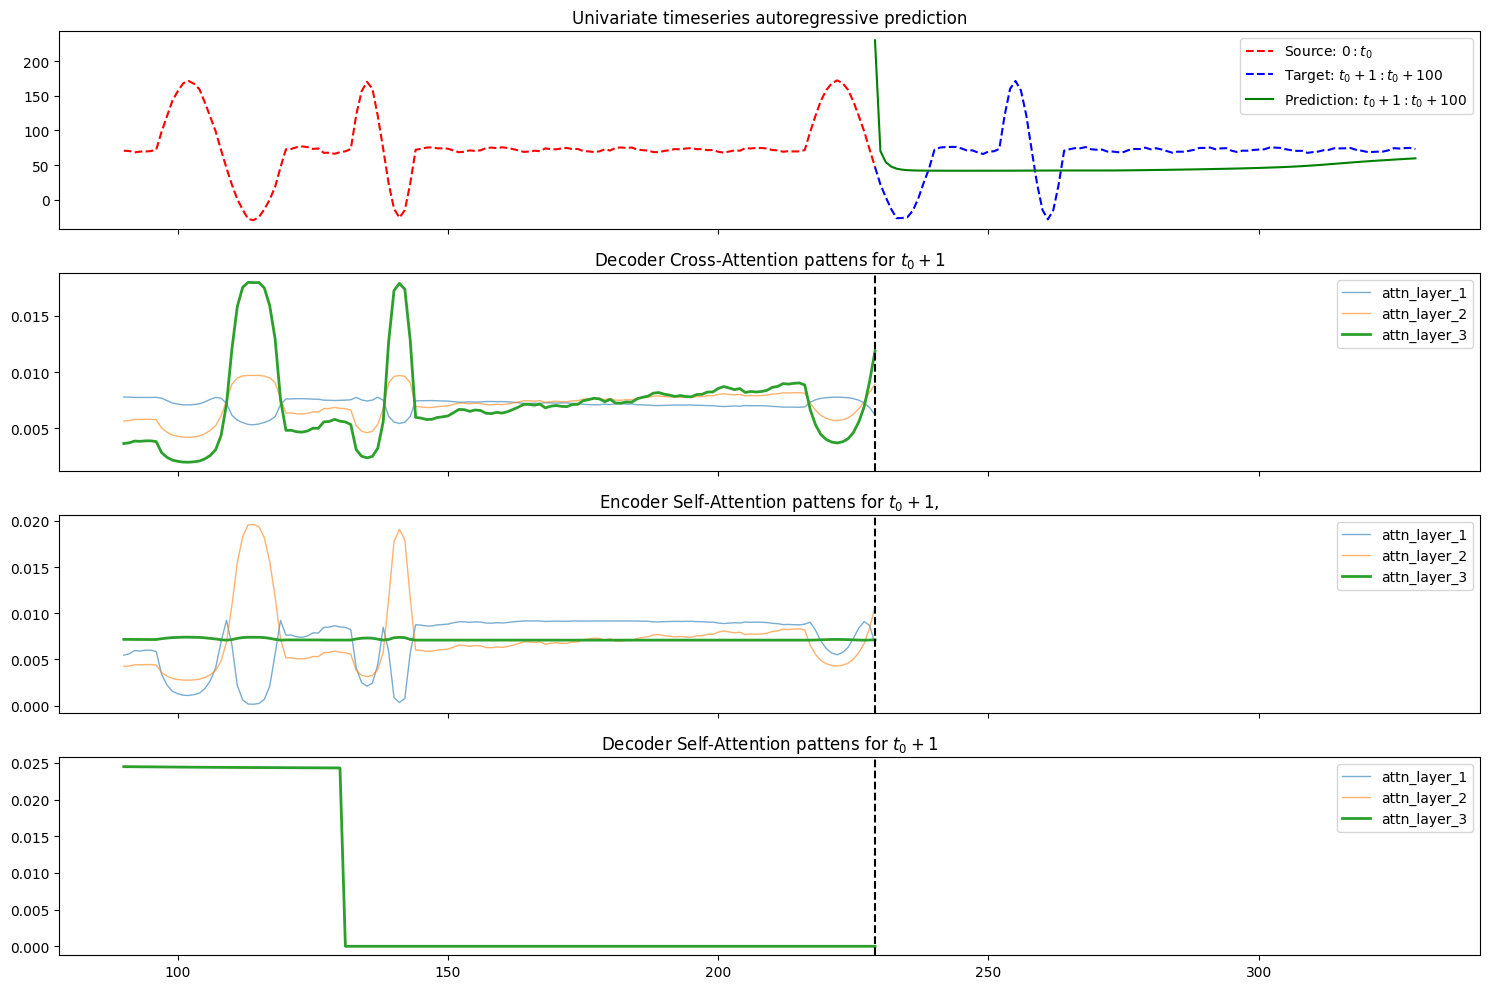

In [33]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X, src_fX, '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X[-horizon-1:], pred_fX[-horizon-1:], '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -horizon, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -horizon, :].cpu()
    if i == n_layers-1:
        ax3.plot(src_X, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(src_X, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax3.axvline(src_X[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -horizon, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax4.axvline(src_X[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
# fig.savefig("../../img/baseline_enc_dec/enc_dec_baseline_attn_1pred_at_once.pdf", dpi=1200)

## Experiment 2: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target

### Configs

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model)
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1032                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.8                          # learning rate decrease rate

EPOCHS = 20                             # training epochs

### Dataset splits

In [36]:
dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

# dataset.fX = (dataset.fX - torch.mean(dataset.fX, dim=0, keepdim=True)) / torch.std(dataset.fX, dim=0, keepdim=True)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

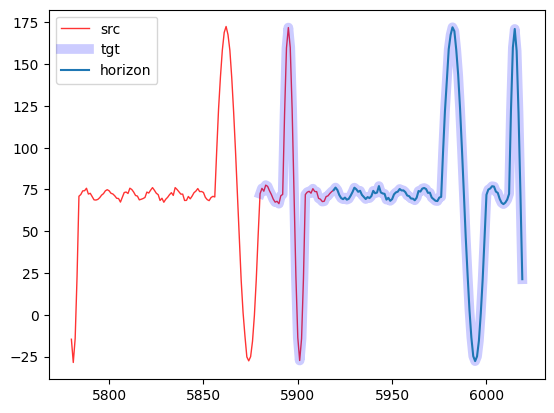

In [37]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [39]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [40]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, 0, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, 0, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step() # \tlr={scheduler.get_last_lr()}
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=2163.6246	val_loss=1504.6342	R_p=['0.2771', '0.2963']
epoch=1	train_loss=1531.9025	val_loss=1500.7609	R_p=['0.2742', '0.2636']
epoch=2	train_loss=1395.2705	val_loss=1375.3747	R_p=['0.2944', '0.2433']
epoch=3	train_loss=987.7380	val_loss=804.4061	R_p=['0.2460', '0.1726']
epoch=4	train_loss=366.9584	val_loss=529.4534	R_p=['0.1743', '0.1195']
epoch=5	train_loss=160.4480	val_loss=685.1283	R_p=['0.2497', '0.1154']
epoch=6	train_loss=119.4725	val_loss=248.7884	R_p=['0.1353', '0.1781']
epoch=7	train_loss=103.4598	val_loss=555.1440	R_p=['0.1912', '0.0920']
epoch=8	train_loss=87.4062	val_loss=474.3571	R_p=['0.1783', '0.0910']
epoch=9	train_loss=74.6134	val_loss=121.2249	R_p=['0.0948', '0.1187']
epoch=10	train_loss=70.1514	val_loss=711.7283	R_p=['0.2211', '0.0883']
epoch=11	train_loss=68.1535	val_loss=830.8235	R_p=['0.2346', '0.0716']
epoch=12	train_loss=68.3986	val_loss=78.8119	R_p=['0.0708', '0.0673']
epoch=13	train_loss=61.5774	val_loss=236.8977	R_p=['0.1137', '0.0668']
epo

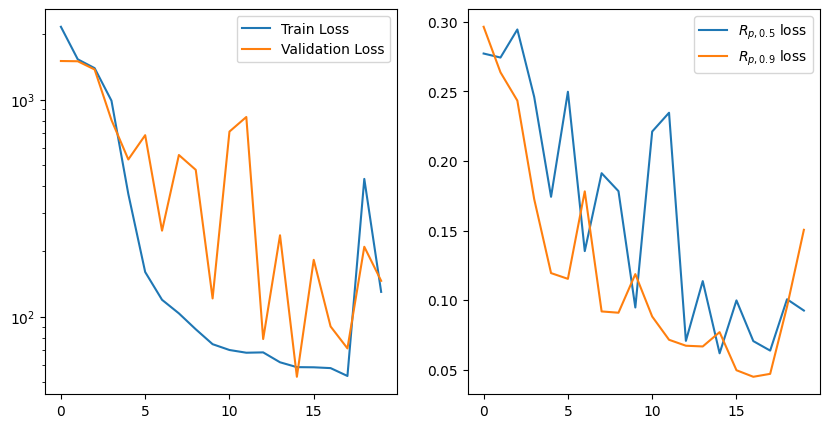

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend() 

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [42]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, r_ps

(151.2769930419922, tensor([0.0948, 0.1545], device='cuda:0'))

### Predict

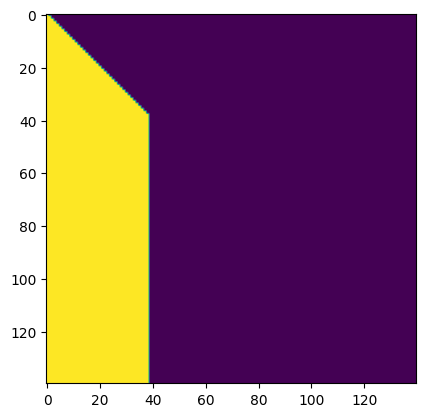

In [43]:
mask = dataset.mask

mask2 = torch.clone(mask)
mask2[:, -shift-1:] = 0

plt.imshow(mask2.cpu())

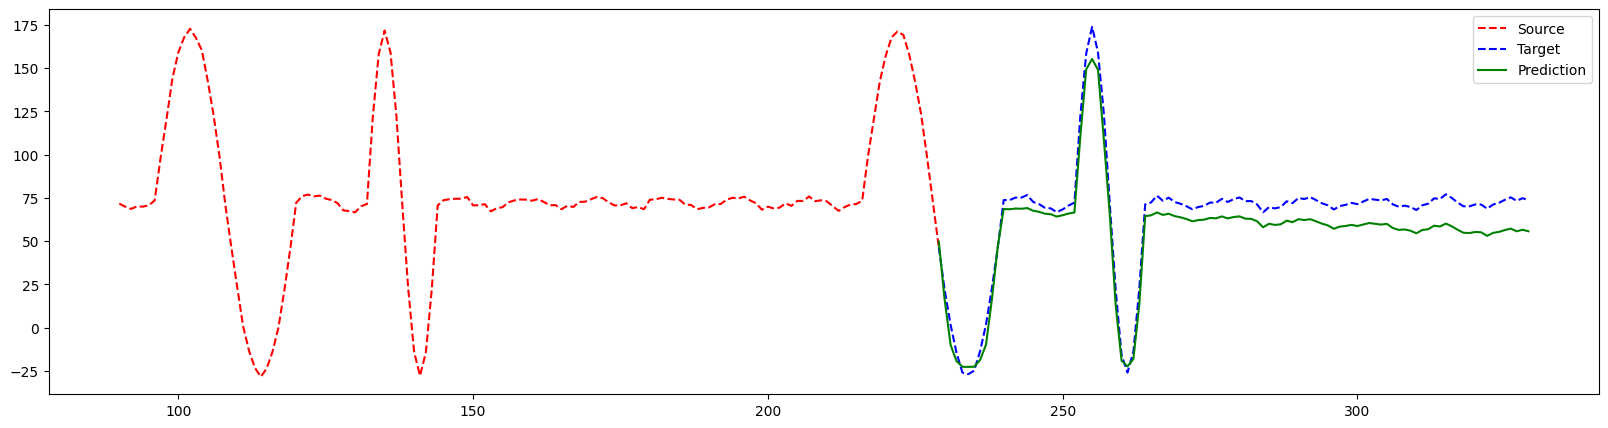

In [44]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    
    mask2 = mask2.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask2)
    pred_fX = out[:, -shift-1:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift-1:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift-1:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [47]:
inspect_step = 0

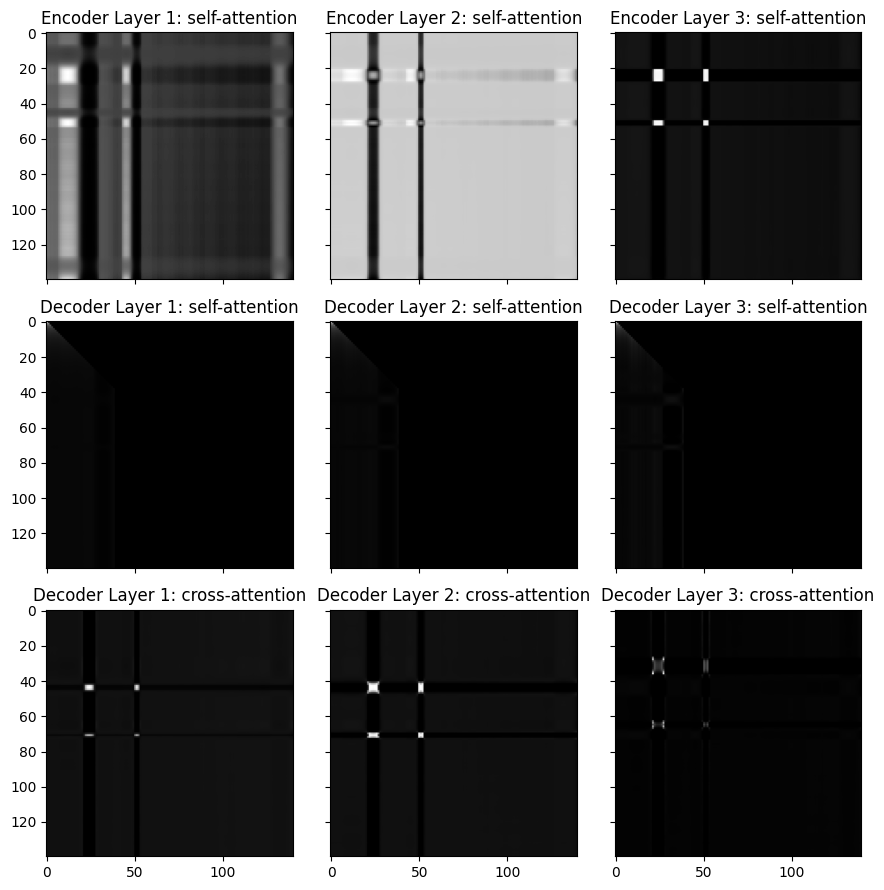

In [48]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, :].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, :].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, :].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

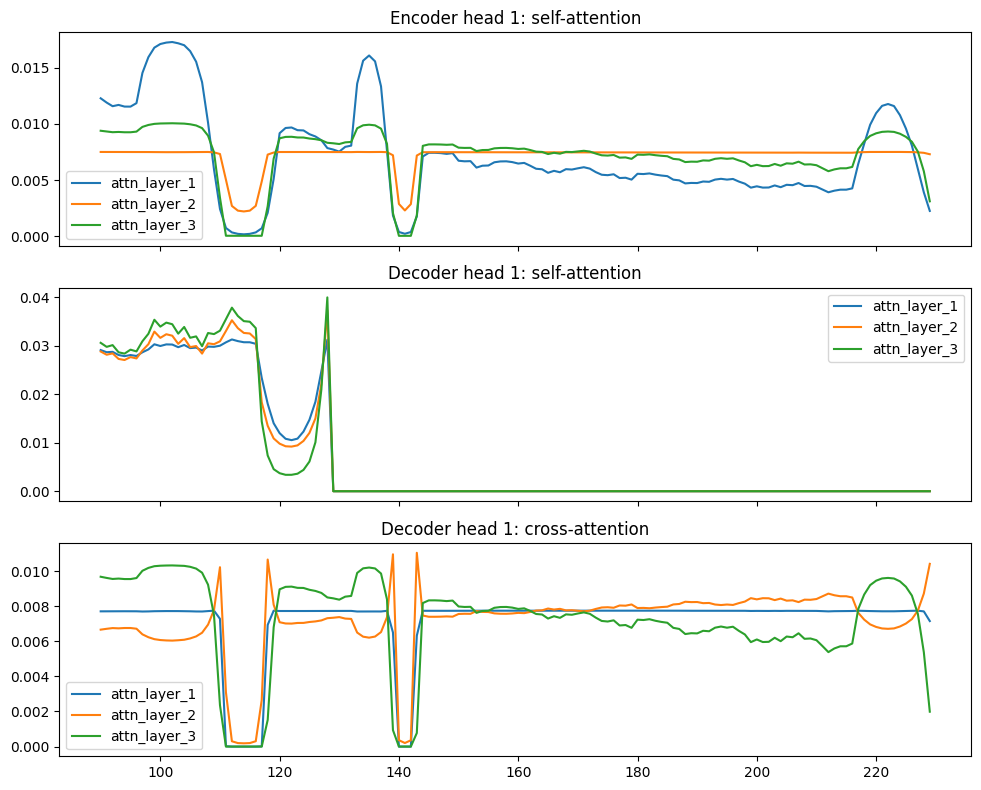

In [49]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -horizon, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -horizon, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -horizon, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

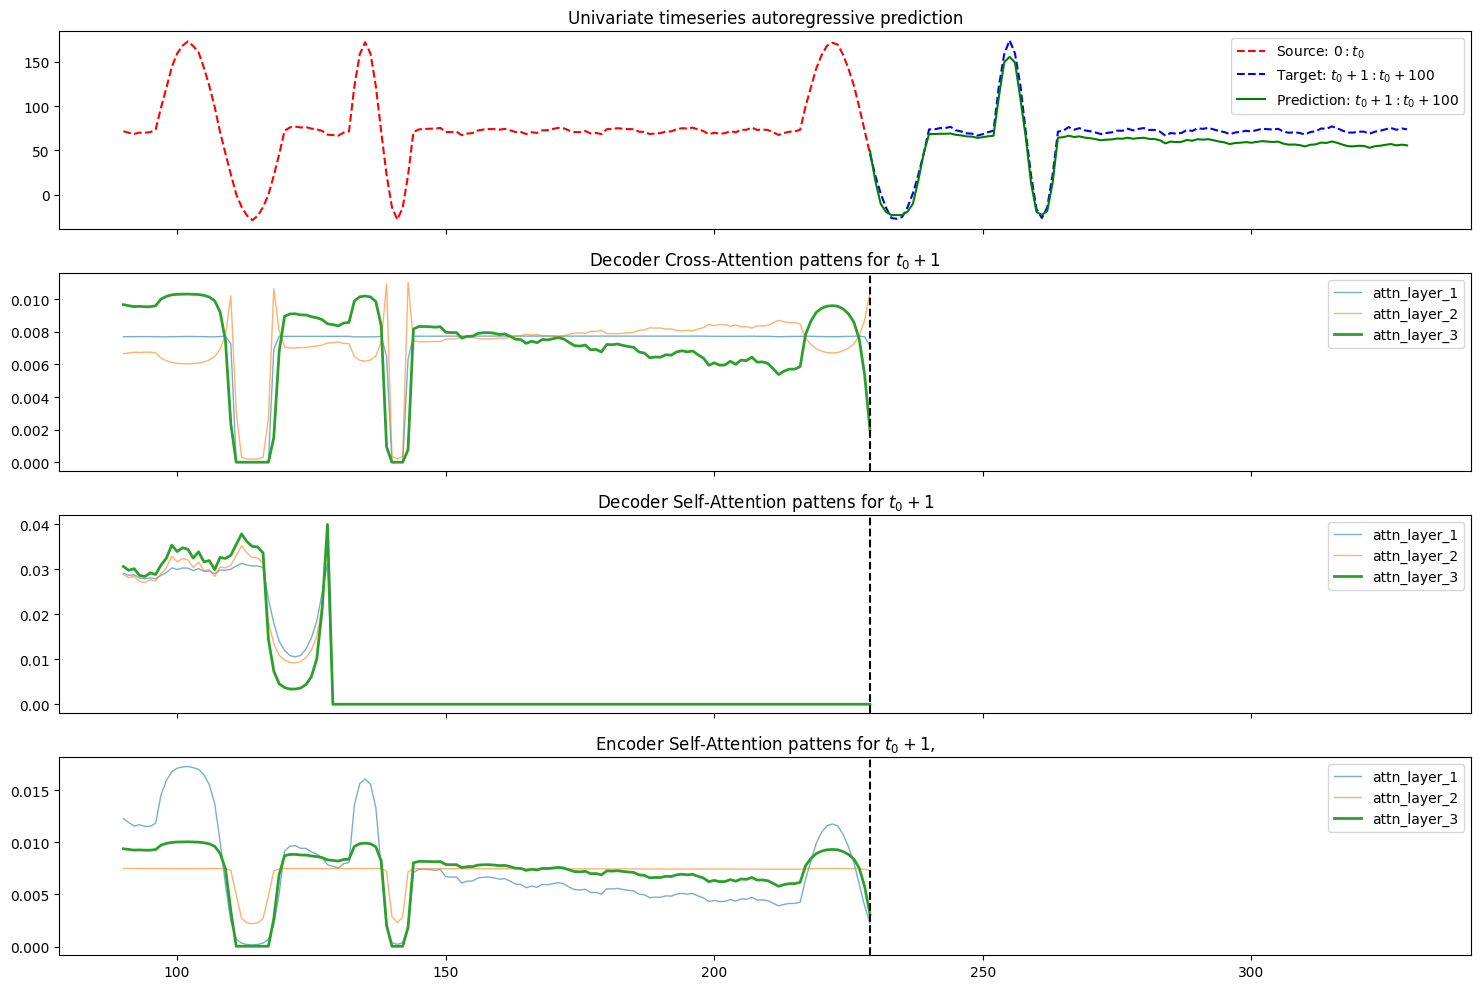

In [51]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
# fig.savefig(f"../../img/baseline_enc_dec/enc_dec_baseline_attn_{shift}pred_at_once.pdf", dpi=1200)

## Experiment 3: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target 

### Configs

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 64                           # size of transformer block embedding (d_model)
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.8                          # learning rate decrease rate

EPOCHS = 20                             # training epochs

### Dataset splits

In [63]:
dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

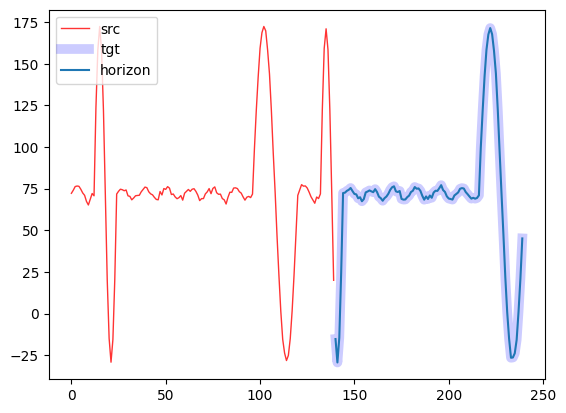

In [64]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [66]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

### Training

In [67]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [68]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=1988.0545	val_loss=1483.8033	R_p=['0.2702', '0.2678']
epoch=1	train_loss=1522.4466	val_loss=1468.5864	R_p=['0.2728', '0.2863']
epoch=2	train_loss=1012.1017	val_loss=1073.9053	R_p=['0.2847', '0.3755']
epoch=3	train_loss=185.9887	val_loss=714.2487	R_p=['0.2285', '0.1058']
epoch=4	train_loss=124.0988	val_loss=903.5250	R_p=['0.3101', '0.0961']
epoch=5	train_loss=87.6502	val_loss=523.3481	R_p=['0.1840', '0.0855']
epoch=6	train_loss=62.4915	val_loss=1105.1021	R_p=['0.3039', '0.0922']
epoch=7	train_loss=61.6503	val_loss=1675.1953	R_p=['0.3816', '0.1061']
epoch=8	train_loss=48.9116	val_loss=2257.4291	R_p=['0.4370', '0.1190']
epoch=9	train_loss=47.5505	val_loss=2216.7048	R_p=['0.4426', '0.1029']
epoch=10	train_loss=41.4804	val_loss=1204.1322	R_p=['0.2974', '0.0841']
epoch=11	train_loss=40.7881	val_loss=555.9548	R_p=['0.1896', '0.0684']
epoch=12	train_loss=39.9966	val_loss=472.5408	R_p=['0.1721', '0.0760']
epoch=13	train_loss=39.4910	val_loss=438.3321	R_p=['0.1635', '0.0598']


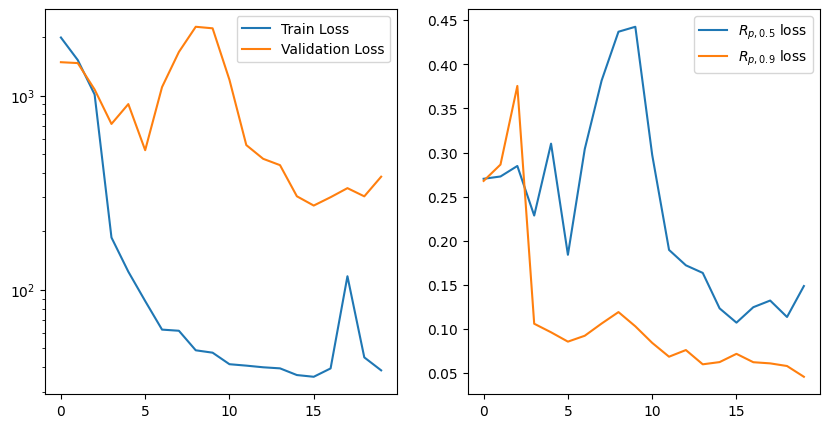

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [70]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, r_ps

(392.8990771484375, tensor([0.1516, 0.0461], device='cuda:0'))

### Predict

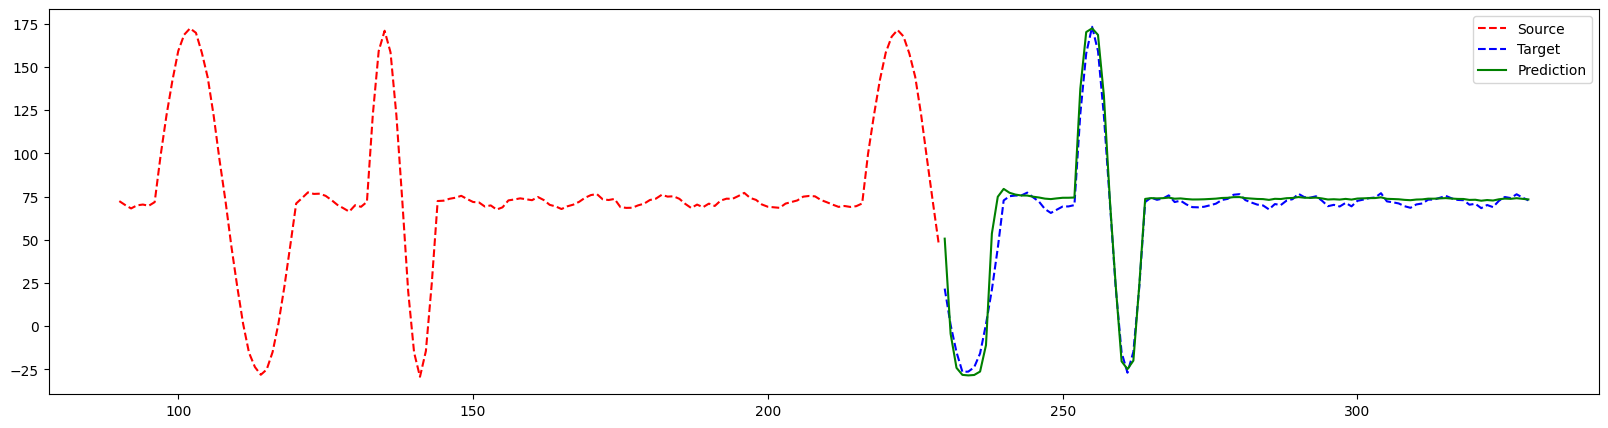

In [71]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [72]:
inspect_step = 0

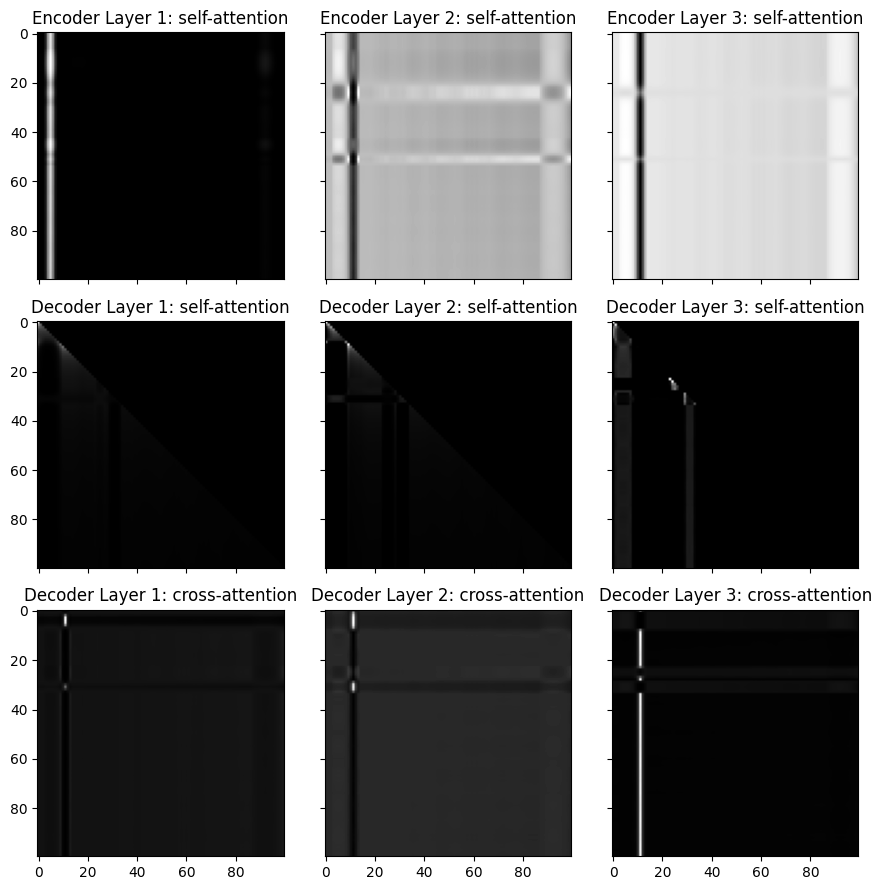

In [73]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

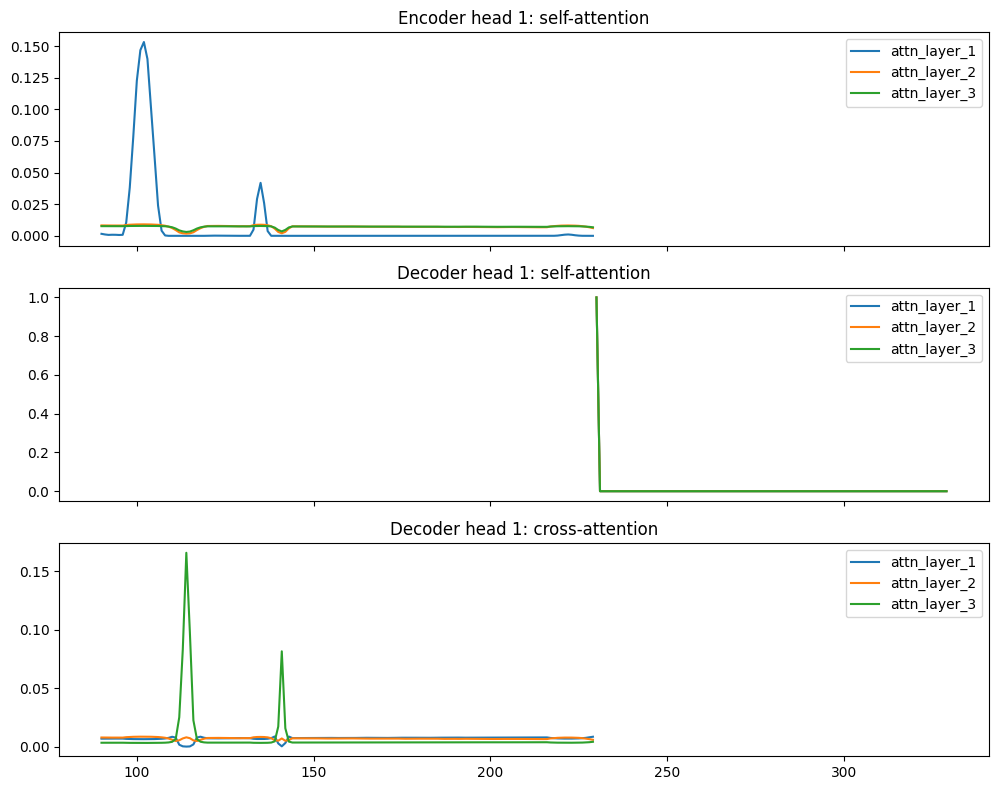

In [74]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

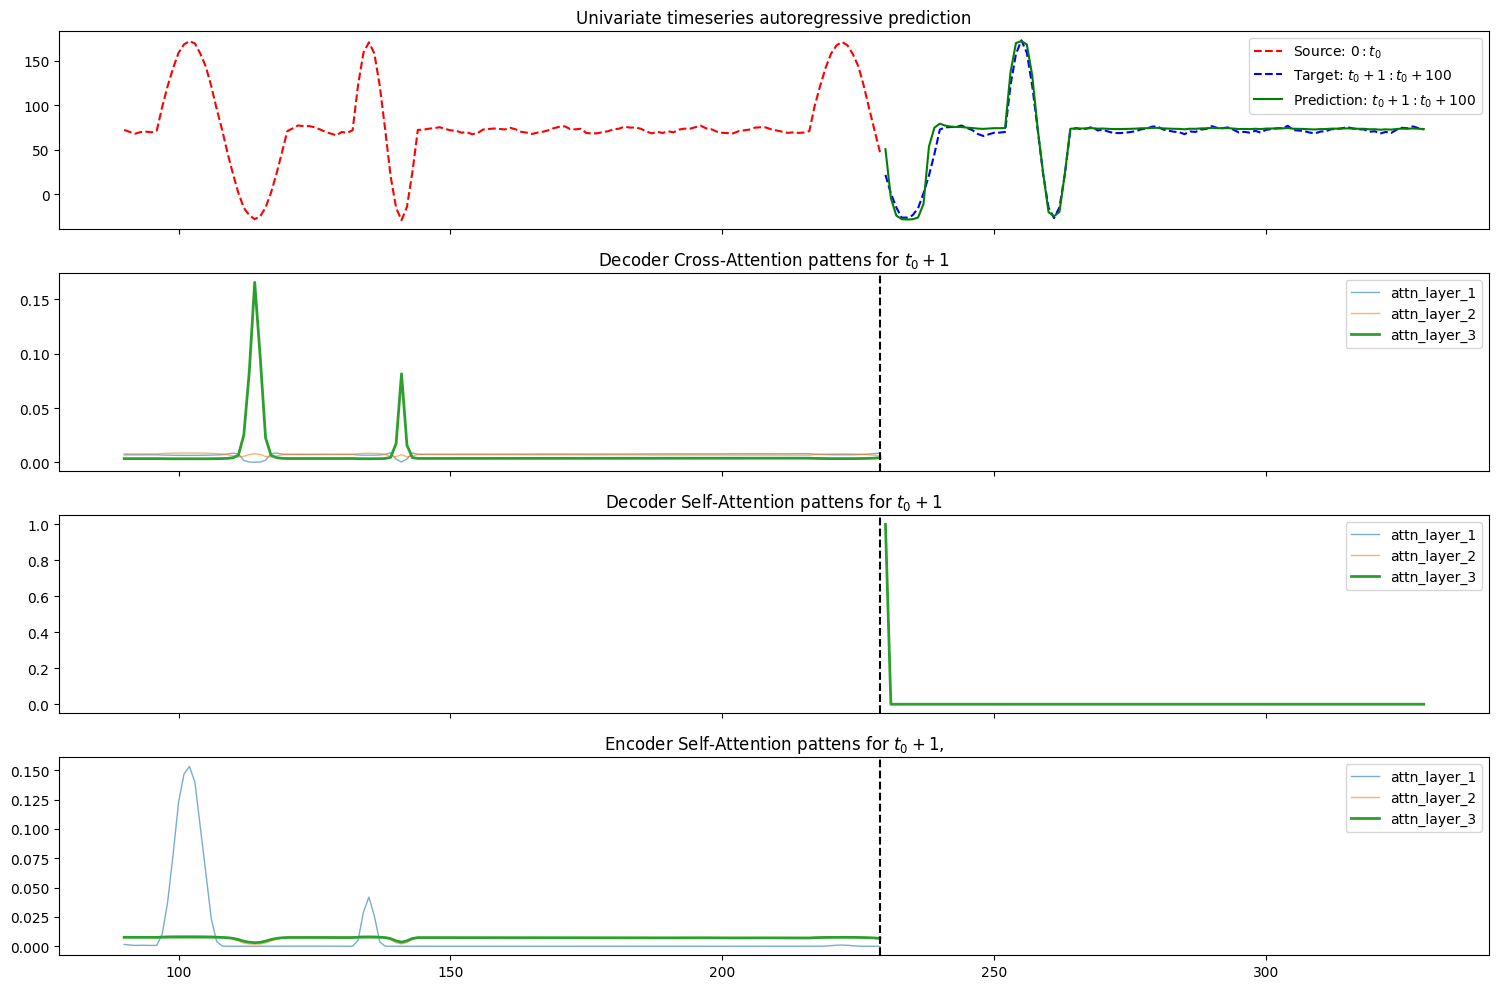

In [76]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
# fig.savefig(f"../../img/baseline_enc_dec/enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)

## Experiment 4: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series

### Configs

In [77]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 20                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 100                             # training epochs

### Dataset splits

In [78]:
dataset = SD.MultivarPeriodicDataset(len_timeseries=total_length, n_timeseries=n_timeseries, seq_len=seq_len, shift=shift, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 20]),
 torch.Size([100, 1]),
 torch.Size([100, 20]))

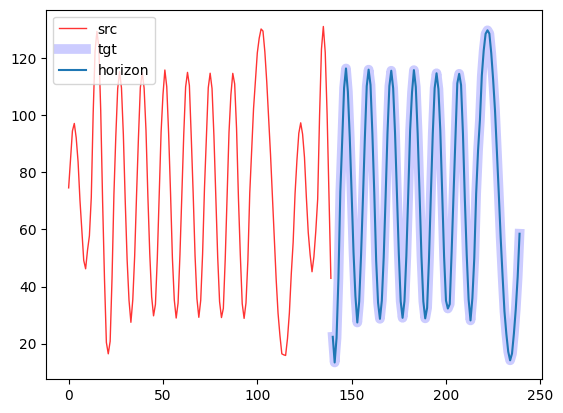

In [79]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

ith = 0 # i-th time series

plt.plot(src_X, src_fX[:, ith], 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX[:, ith], '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:, ith], tgt_fX[-shift-1:, ith], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

### Training setup

In [80]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

### Training

In [83]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [84]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=1808.6779	val_loss=632.1532	R_p=['0.2724', '0.3257']
epoch=1	train_loss=697.3483	val_loss=622.7193	R_p=['0.2685', '0.3097']
epoch=2	train_loss=556.9281	val_loss=732.8625	R_p=['0.3030', '0.4272']
epoch=3	train_loss=233.7651	val_loss=694.1042	R_p=['0.2791', '0.4198']
epoch=4	train_loss=160.3171	val_loss=519.1645	R_p=['0.2391', '0.3427']
epoch=5	train_loss=142.1513	val_loss=370.6903	R_p=['0.1996', '0.2806']
epoch=6	train_loss=132.3604	val_loss=262.1121	R_p=['0.1646', '0.2386']
epoch=7	train_loss=123.8458	val_loss=181.0001	R_p=['0.1336', '0.1947']
epoch=8	train_loss=117.2403	val_loss=182.7998	R_p=['0.1342', '0.2032']
epoch=9	train_loss=110.8738	val_loss=182.2305	R_p=['0.1281', '0.1961']
epoch=10	train_loss=97.2521	val_loss=182.0560	R_p=['0.1230', '0.2011']
epoch=11	train_loss=77.6536	val_loss=115.9177	R_p=['0.0952', '0.1474']
epoch=12	train_loss=65.1145	val_loss=109.2402	R_p=['0.0892', '0.1360']
epoch=13	train_loss=59.6141	val_loss=103.2406	R_p=['0.0853', '0.1367']
epoch

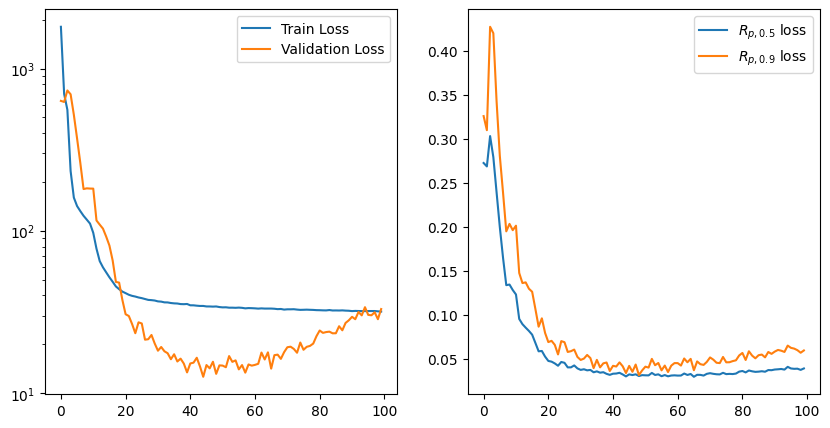

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

### Testing model

In [86]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(33.33570288085937, tensor([0.0391, 0.0595], device='cuda:0'))

### Predict

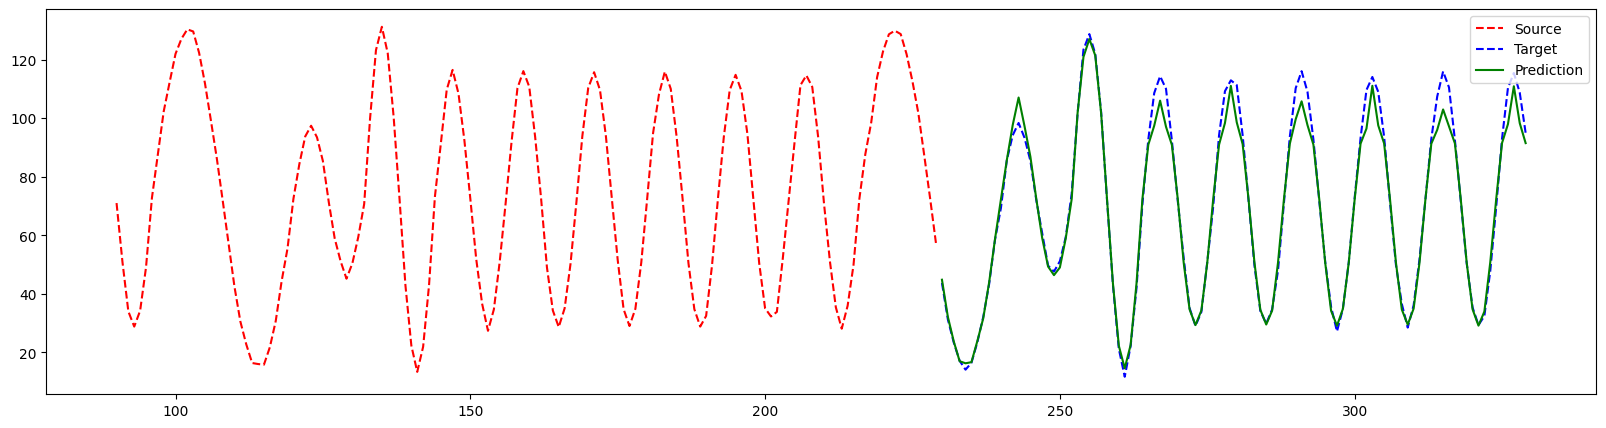

In [89]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

ith = 0

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source")
plt.plot(pred_X, tgt_fX[:, ith], '--b', label="Target")
plt.plot(pred_X, pred_fX[:, ith], '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [91]:
inspect_step = 0

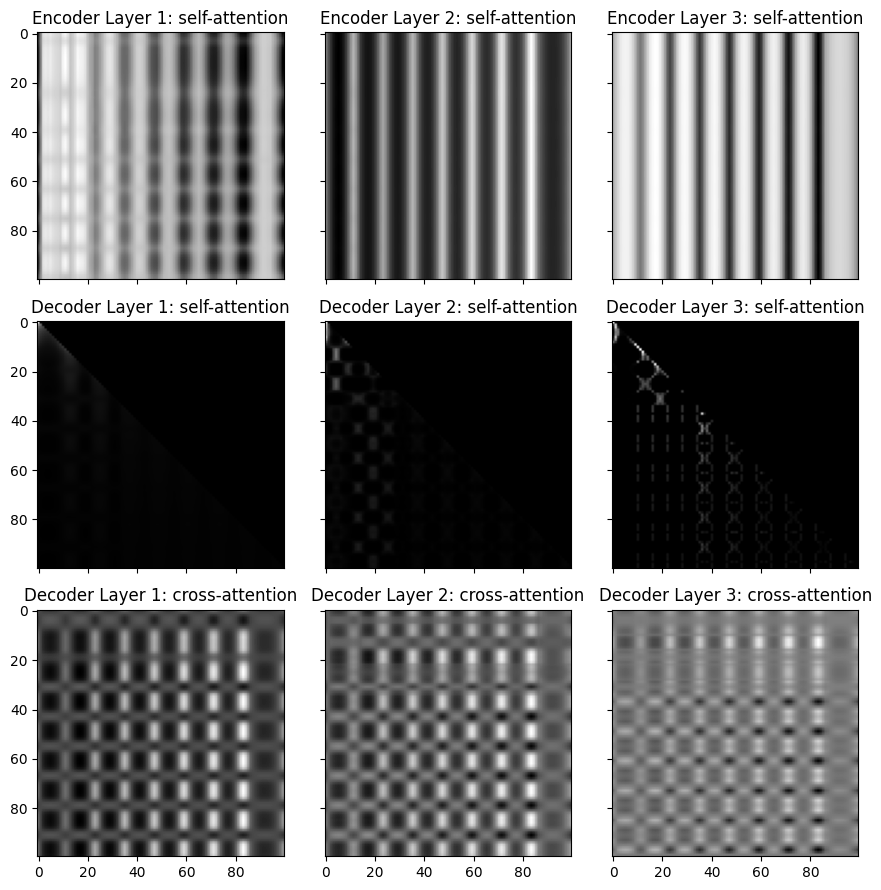

In [92]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

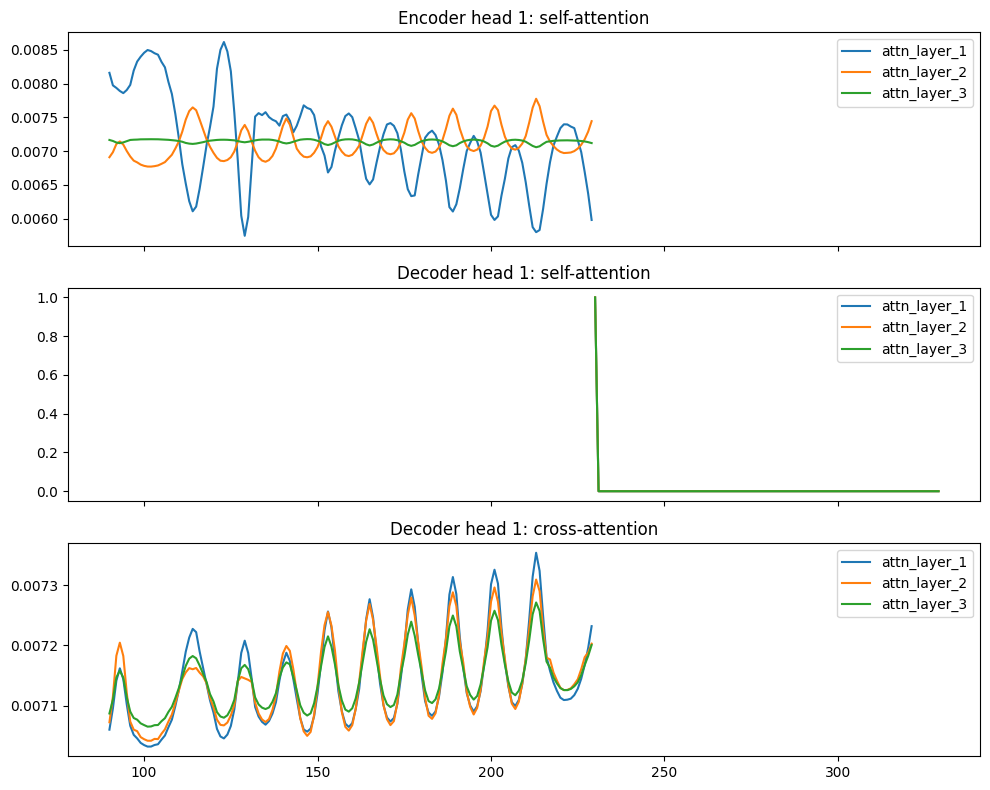

In [93]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

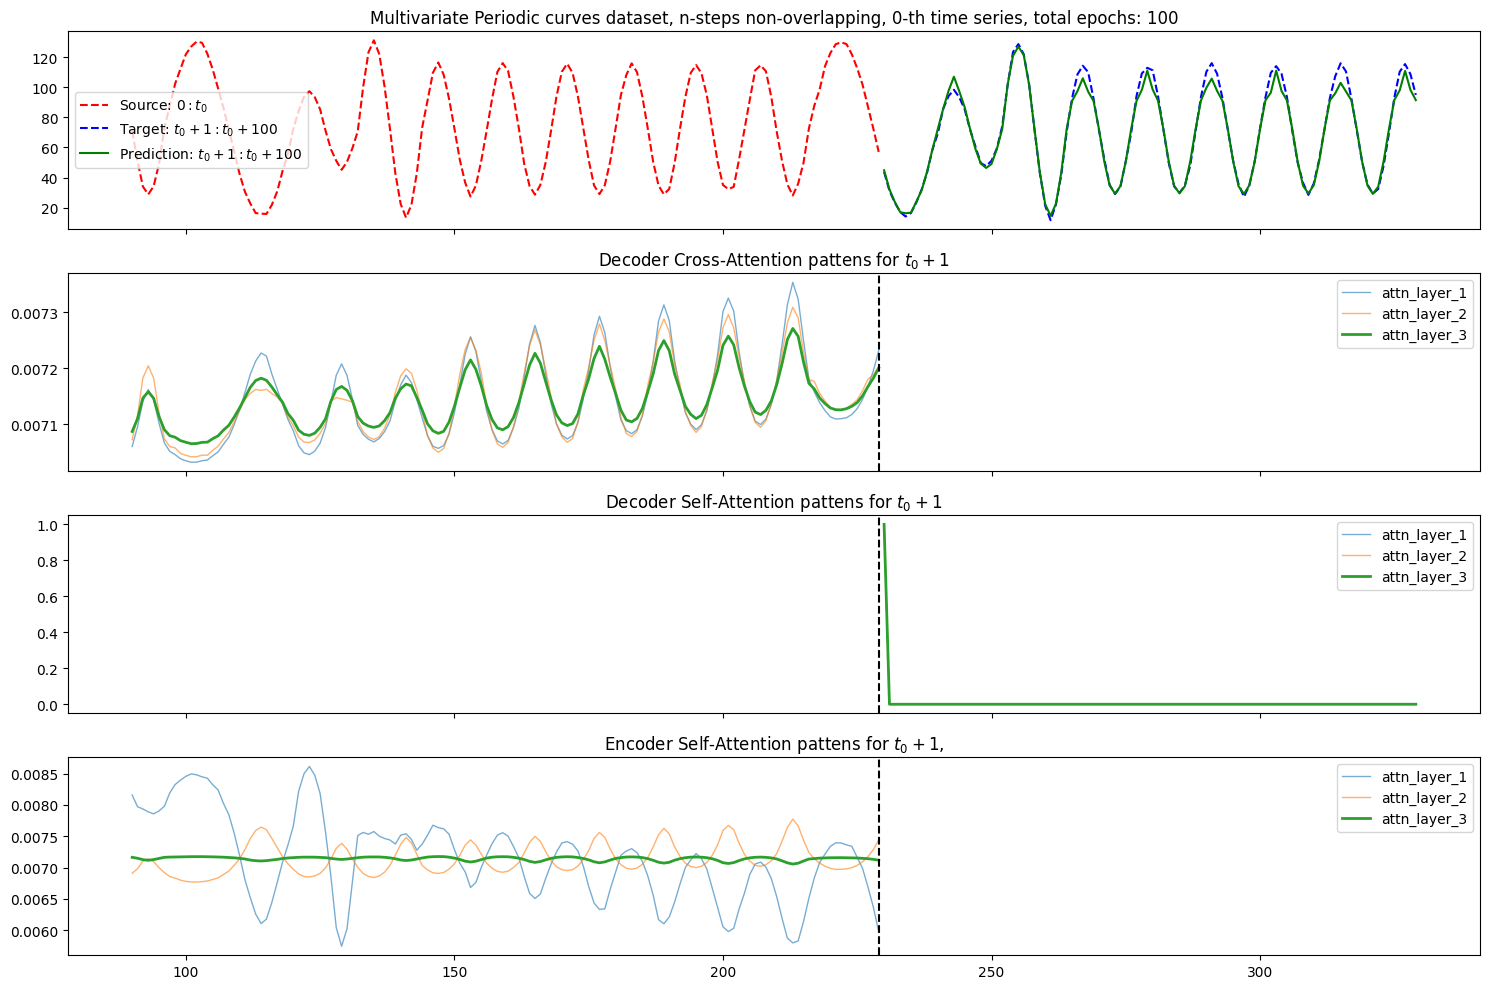

In [97]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX[:, ith], '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu()[:, ith], '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Multivariate Periodic curves dataset, n-steps non-overlapping, {ith}-th time series, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
fig.savefig(f"../../img/baseline_enc_dec/multivar_enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)

## Experiment 5: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target

In [98]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 50                             # training epochs

### Step function

#### Dataset splits

In [99]:
dataset = SD.StepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

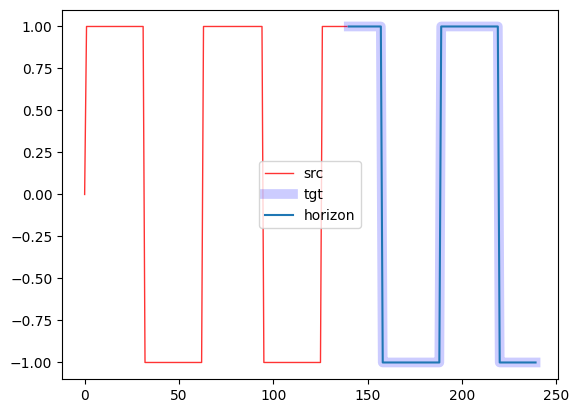

In [100]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [102]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

#### Training

In [104]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [105]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=1.0447	val_loss=0.9999	R_p=['0.9999', '1.0028']
epoch=1	train_loss=1.0035	val_loss=1.0009	R_p=['1.0002', '1.0250']
epoch=2	train_loss=1.0034	val_loss=1.0025	R_p=['1.0004', '1.0412']
epoch=3	train_loss=1.0031	val_loss=1.0049	R_p=['1.0006', '1.0572']
epoch=4	train_loss=1.0025	val_loss=0.9999	R_p=['0.9999', '1.0016']
epoch=5	train_loss=1.0017	val_loss=0.9999	R_p=['0.9999', '0.9993']
epoch=6	train_loss=1.0026	val_loss=1.0004	R_p=['1.0001', '1.0175']
epoch=7	train_loss=1.0018	val_loss=1.0041	R_p=['1.0005', '1.0525']
epoch=8	train_loss=1.0016	val_loss=1.0008	R_p=['0.9996', '0.9754']
epoch=9	train_loss=1.0028	val_loss=0.9999	R_p=['0.9999', '0.9953']
epoch=10	train_loss=1.0015	val_loss=0.9999	R_p=['0.9999', '1.0008']
epoch=11	train_loss=1.0008	val_loss=1.0000	R_p=['1.0000', '1.0064']
epoch=12	train_loss=1.0017	val_loss=0.9999	R_p=['0.9999', '1.0031']
epoch=13	train_loss=1.0011	val_loss=1.0000	R_p=['0.9998', '0.9908']
epoch=14	train_loss=1.0009	val_loss=1.0005	R_p=['1.0001', 

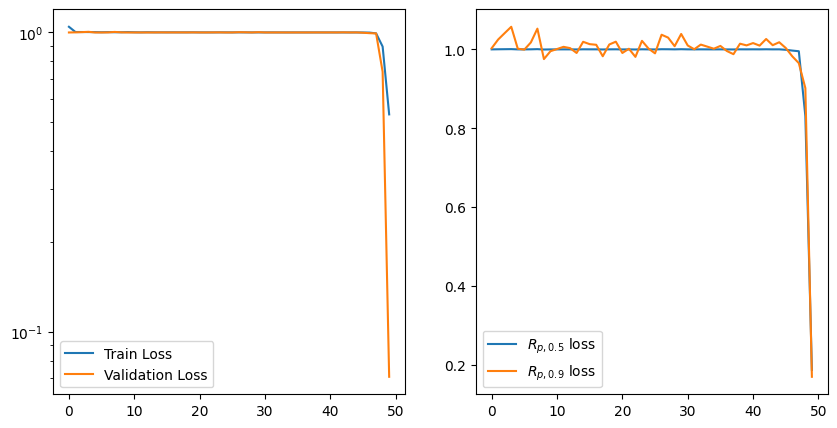

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [107]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.06560412234067917, tensor([0.1814, 0.1644], device='cuda:0'))

#### Predict

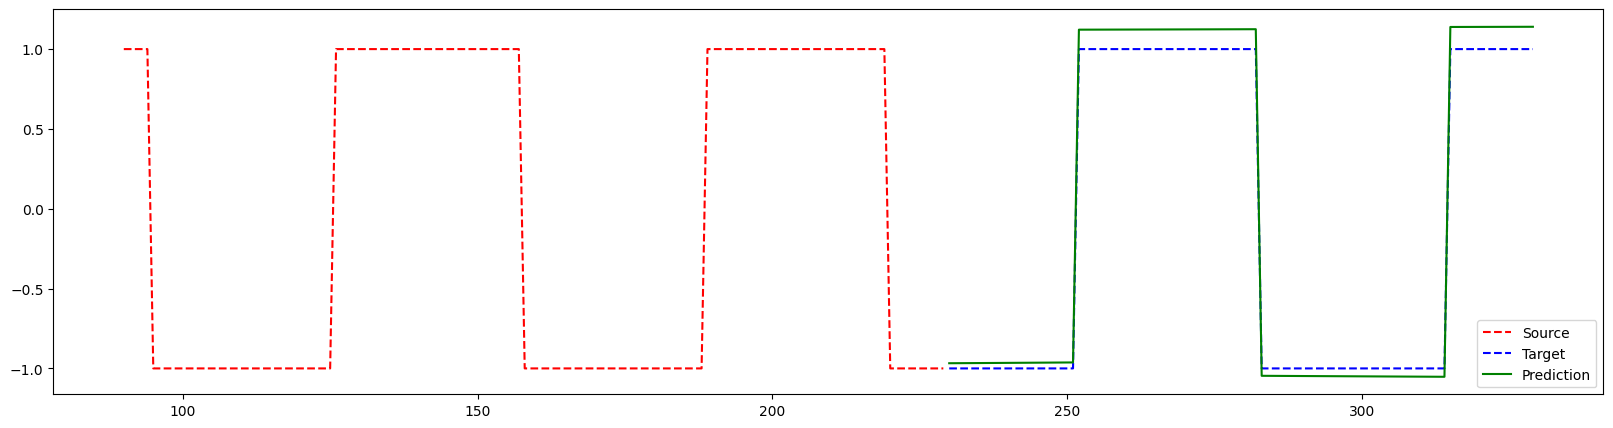

In [109]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [110]:
inspect_step = 0

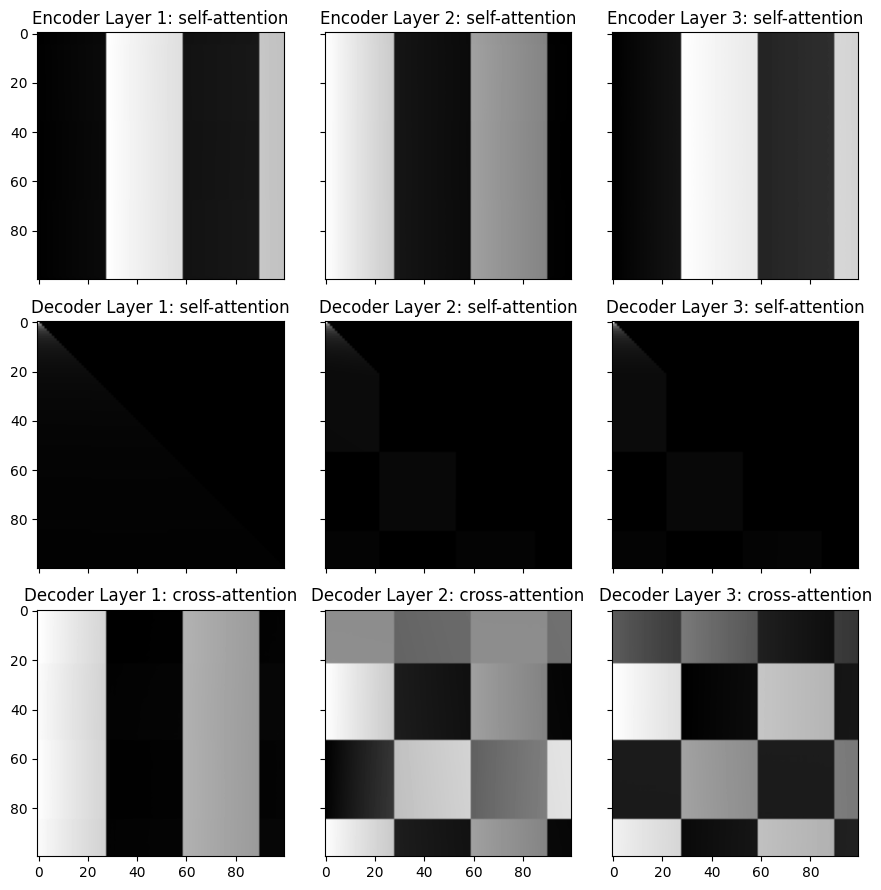

In [111]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

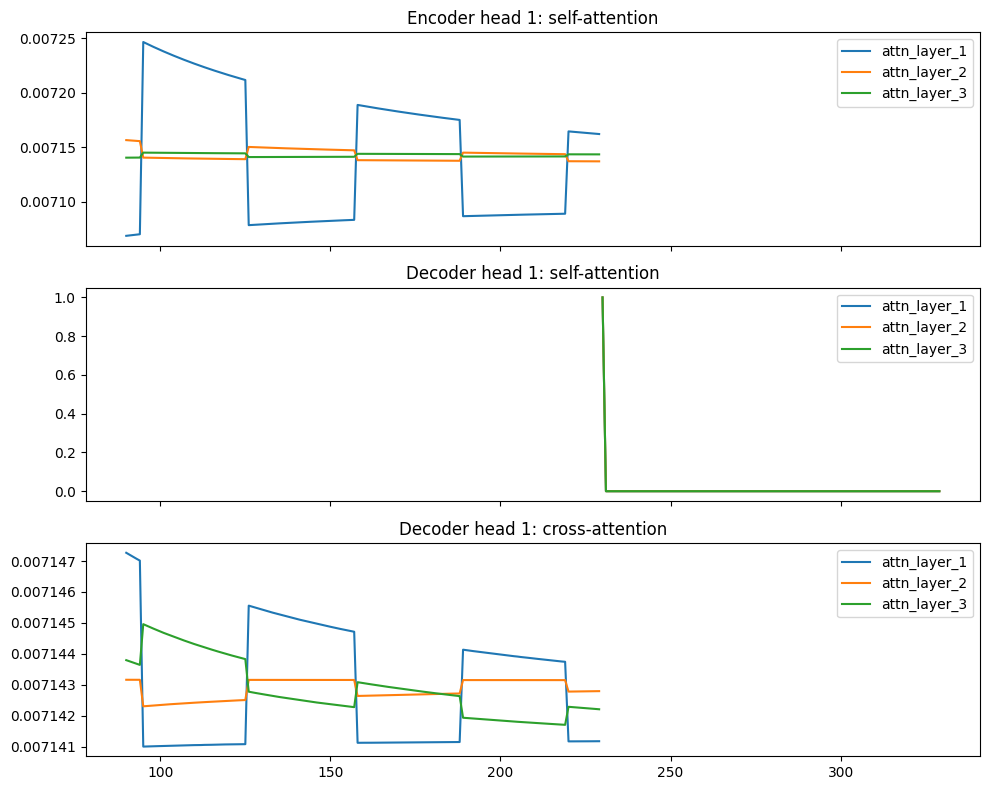

In [112]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

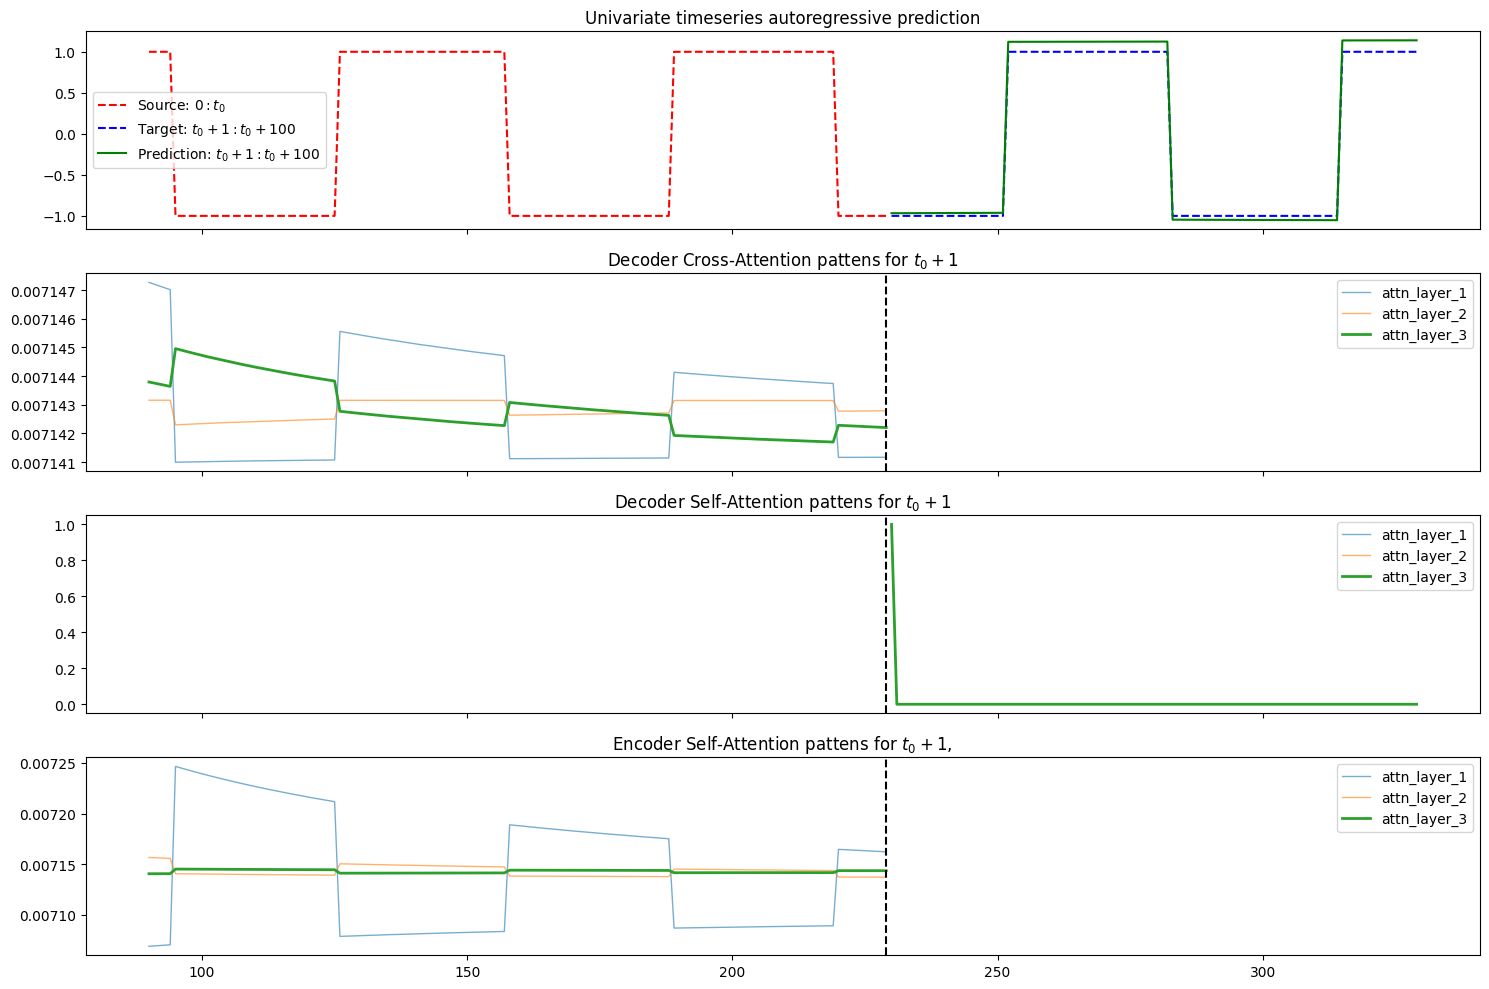

In [114]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
# fig.savefig(f"../../img/baseline_enc_dec/step_enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)

### Decaying Step function

#### Dataset splits

In [117]:
dataset = SD.DecayingStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

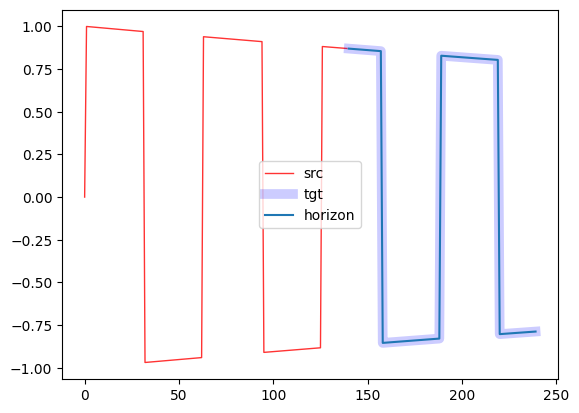

In [118]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [119]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [121]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [122]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.1442	val_loss=0.0580	R_p=['1.0157', '0.9531']
epoch=1	train_loss=0.0603	val_loss=0.0579	R_p=['0.9999', '1.0006']
epoch=2	train_loss=0.0590	val_loss=0.0580	R_p=['1.0043', '1.0601']
epoch=3	train_loss=0.0582	val_loss=0.0579	R_p=['1.0003', '1.0320']
epoch=4	train_loss=0.0582	val_loss=0.0581	R_p=['1.0156', '1.1054']
epoch=5	train_loss=0.0578	val_loss=0.0587	R_p=['1.0492', '1.2122']
epoch=6	train_loss=0.0576	val_loss=0.0583	R_p=['1.0264', '1.1425']
epoch=7	train_loss=0.0574	val_loss=0.0580	R_p=['1.0031', '1.0539']
epoch=8	train_loss=0.0576	val_loss=0.0585	R_p=['1.0521', '0.9096']
epoch=9	train_loss=0.0574	val_loss=0.0580	R_p=['1.0163', '0.9523']
epoch=10	train_loss=0.0571	val_loss=0.0582	R_p=['1.0195', '1.1192']
epoch=11	train_loss=0.0573	val_loss=0.0582	R_p=['1.0227', '1.1302']
epoch=12	train_loss=0.0571	val_loss=0.0585	R_p=['1.0357', '1.1720']
epoch=13	train_loss=0.0573	val_loss=0.0590	R_p=['1.0658', '1.2594']
epoch=14	train_loss=0.0572	val_loss=0.0581	R_p=['1.0210', 

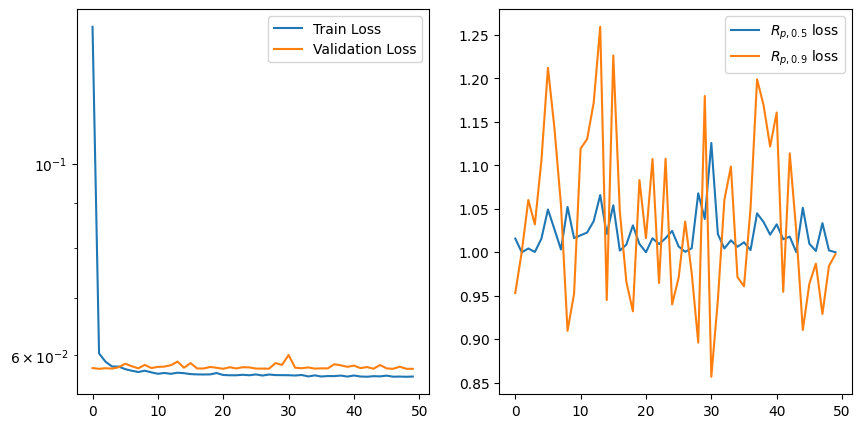

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [124]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.059926301538944245, tensor([1.0003, 0.9799], device='cuda:0'))

#### Predict

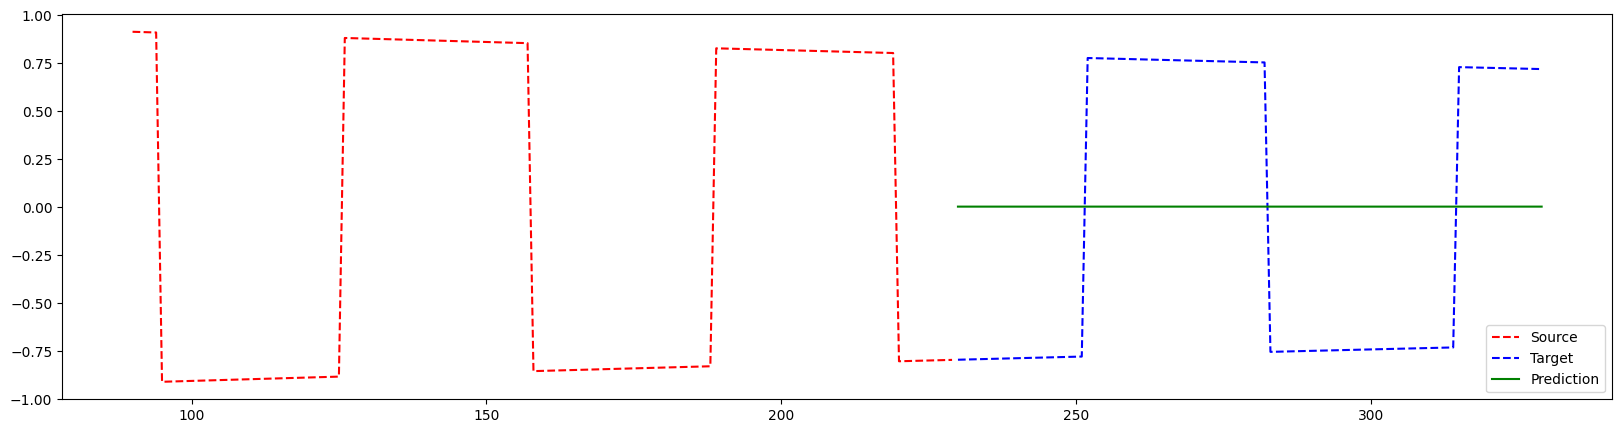

In [125]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [126]:
inspect_step = 0

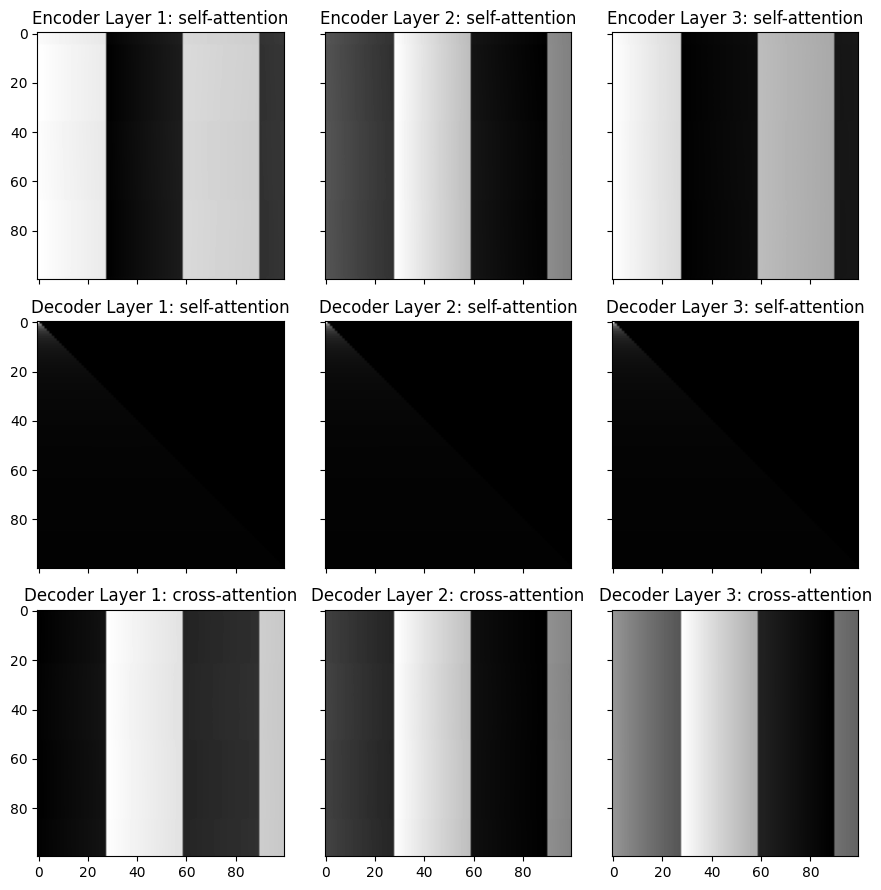

In [127]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

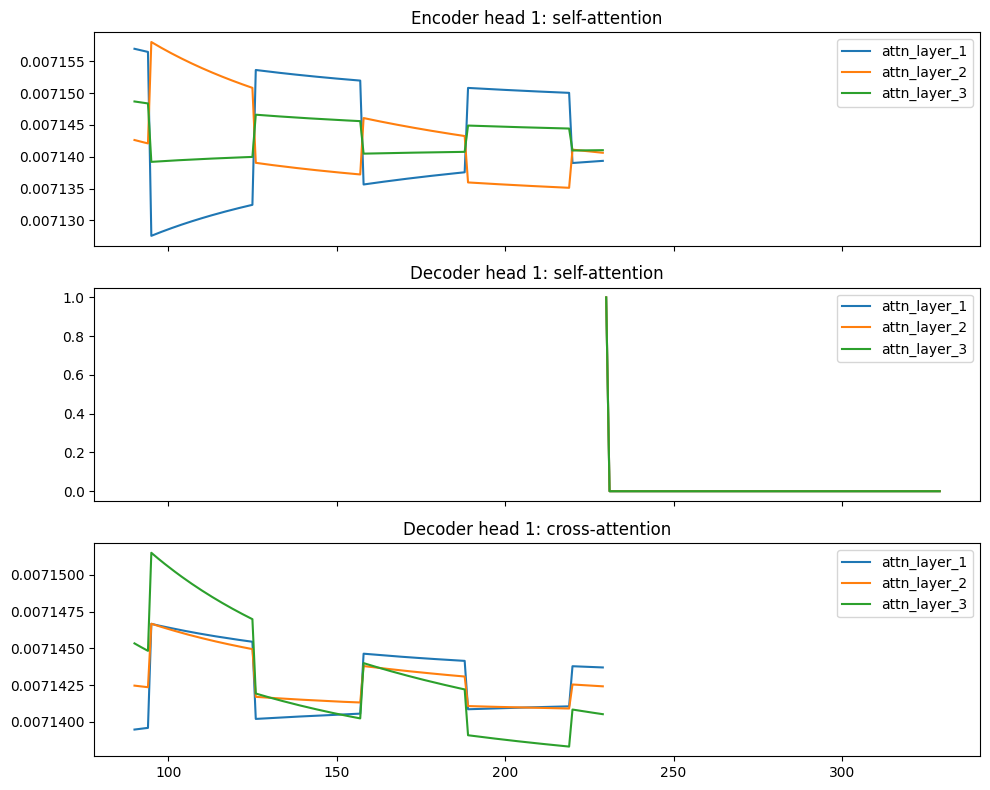

In [128]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

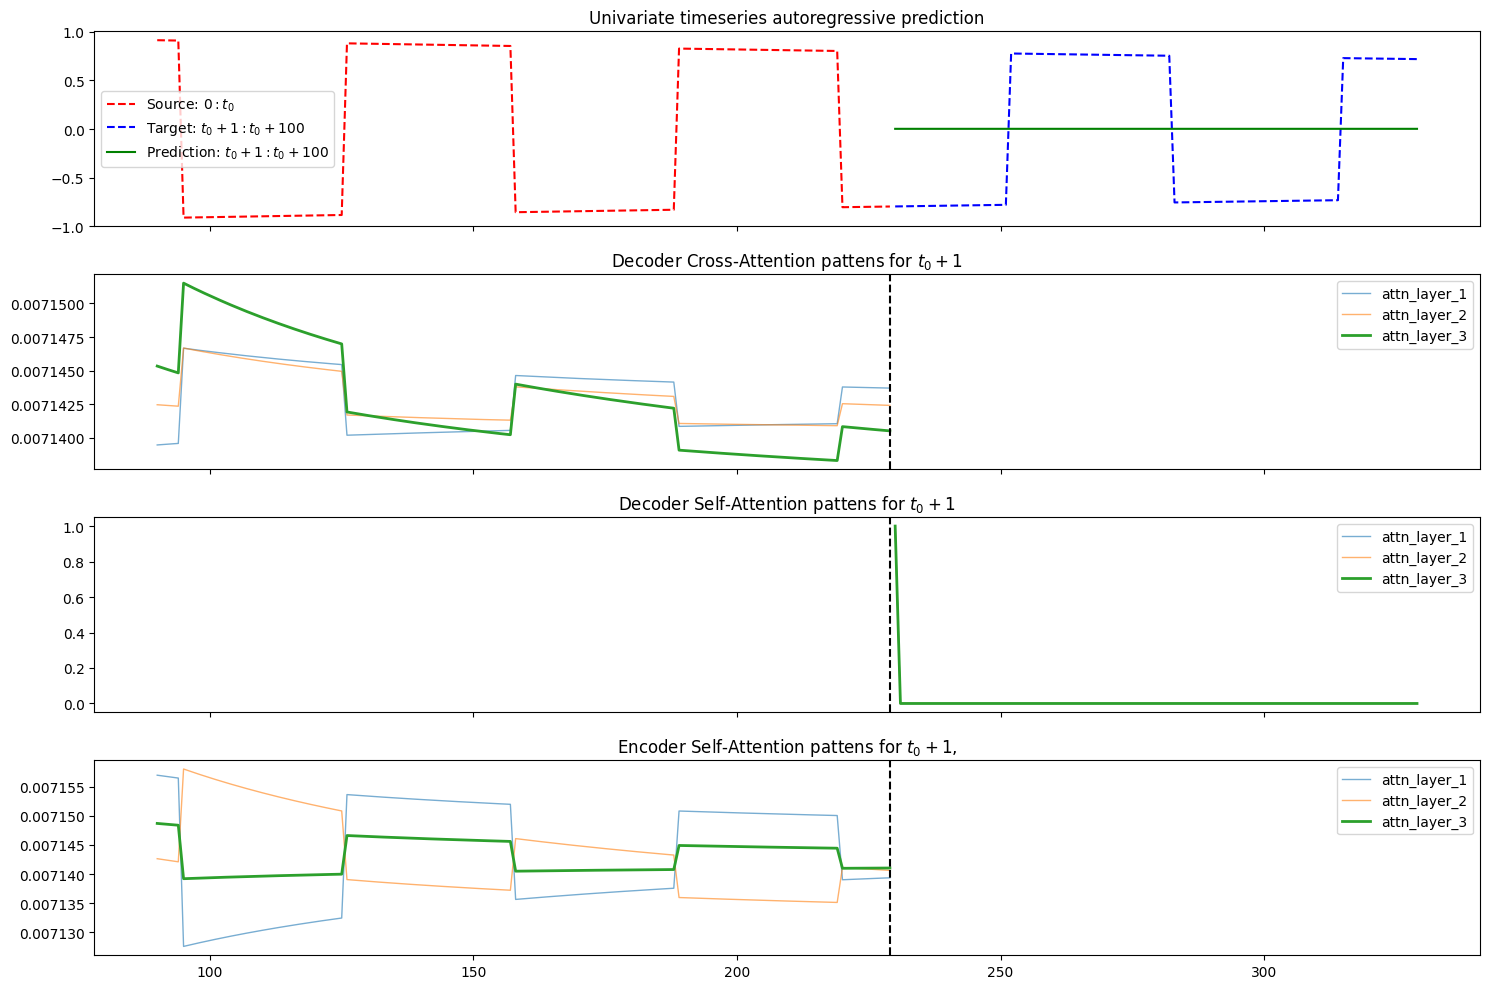

In [131]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
# fig.savefig(f"../../img/baseline_enc_dec/step_decay_enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)

### Multiple Step function

#### Dataset splits

In [132]:
dataset = SD.MultipleStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

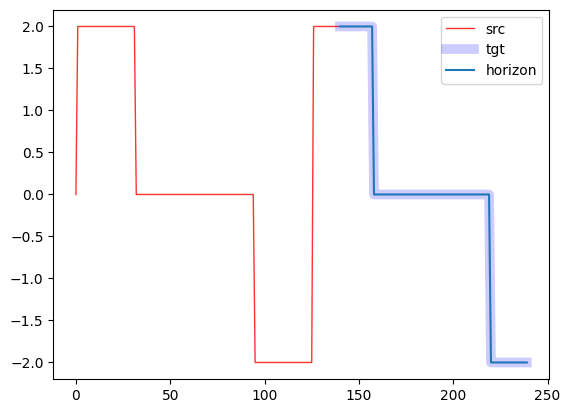

In [133]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [135]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

#### Training

In [136]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [137]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=2.0606	val_loss=2.0163	R_p=['1.0287', '0.9854']
epoch=1	train_loss=2.0085	val_loss=2.0312	R_p=['1.0643', '1.1705']
epoch=2	train_loss=2.0081	val_loss=2.0135	R_p=['1.0038', '1.0130']
epoch=3	train_loss=2.0055	val_loss=2.0136	R_p=['1.0090', '0.9976']
epoch=4	train_loss=2.0075	val_loss=2.0137	R_p=['1.0113', '0.9962']
epoch=5	train_loss=2.0060	val_loss=2.0139	R_p=['1.0089', '1.0265']
epoch=6	train_loss=2.0052	val_loss=2.0134	R_p=['1.0021', '1.0018']
epoch=7	train_loss=2.0065	val_loss=2.0171	R_p=['1.0319', '0.9835']
epoch=8	train_loss=2.0050	val_loss=2.0136	R_p=['1.0092', '0.9975']
epoch=9	train_loss=2.0050	val_loss=2.0135	R_p=['1.0064', '0.9992']
epoch=10	train_loss=2.0037	val_loss=2.0154	R_p=['1.0239', '0.9884']
epoch=11	train_loss=2.0038	val_loss=2.0139	R_p=['1.0089', '1.0264']
epoch=12	train_loss=2.0040	val_loss=2.0147	R_p=['1.0158', '1.0444']
epoch=13	train_loss=2.0031	val_loss=2.0135	R_p=['1.0046', '1.0151']
epoch=14	train_loss=2.0029	val_loss=2.0133	R_p=['1.0021', 

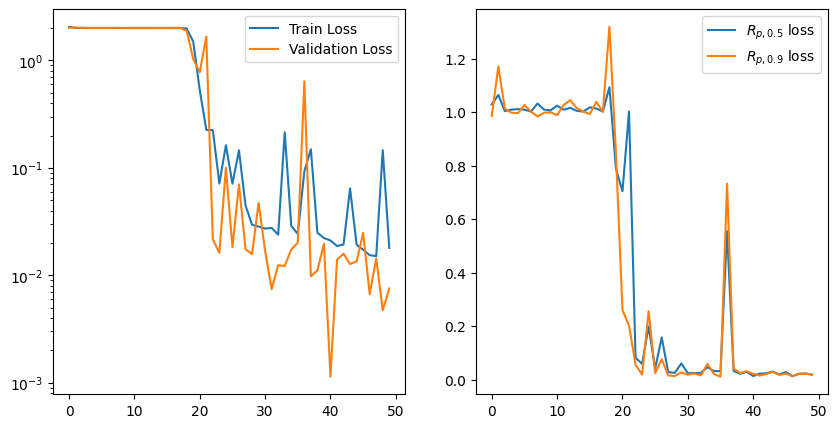

In [138]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [139]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.010021987666841597, tensor([0.0187, 0.0178], device='cuda:0'))

#### Predict

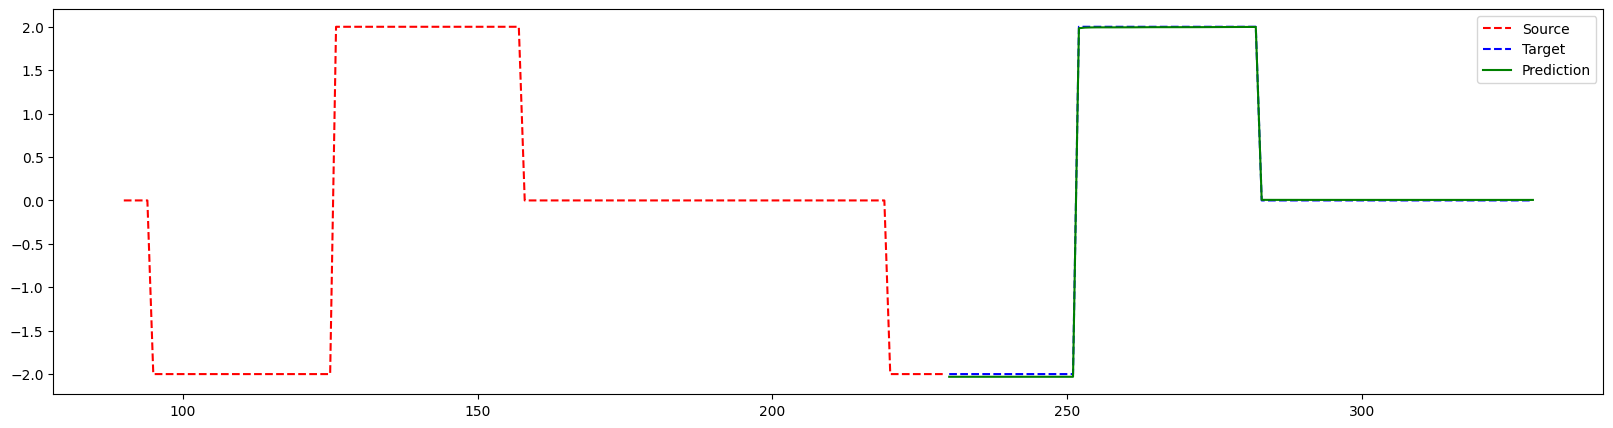

In [140]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [141]:
inspect_step = 0

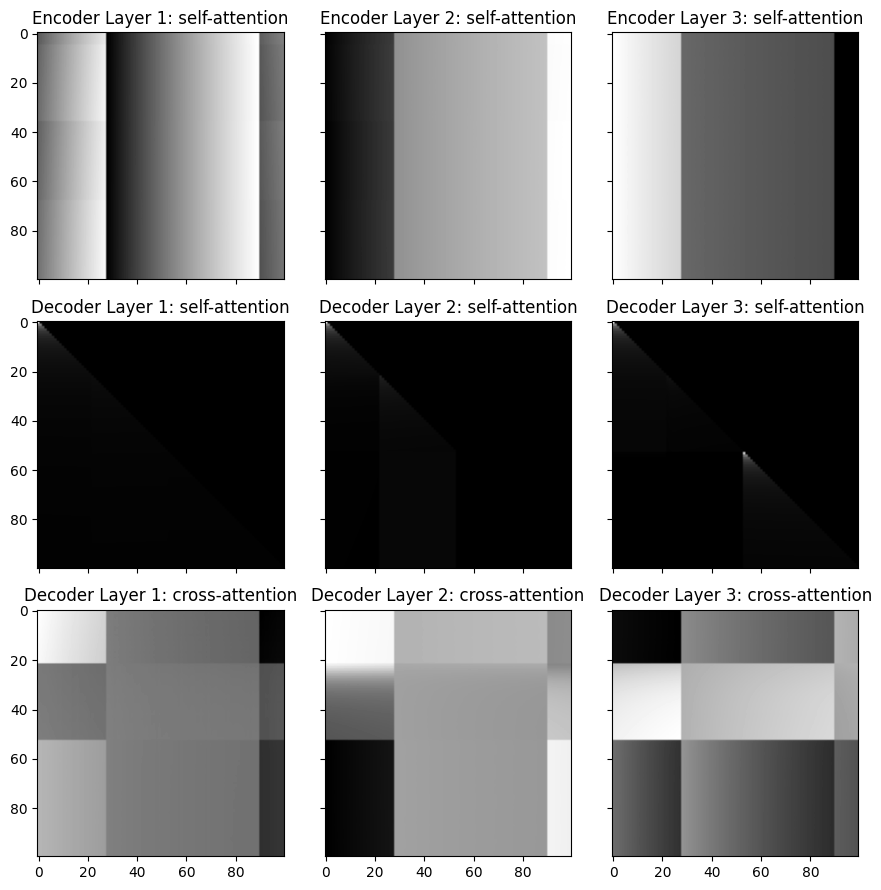

In [142]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

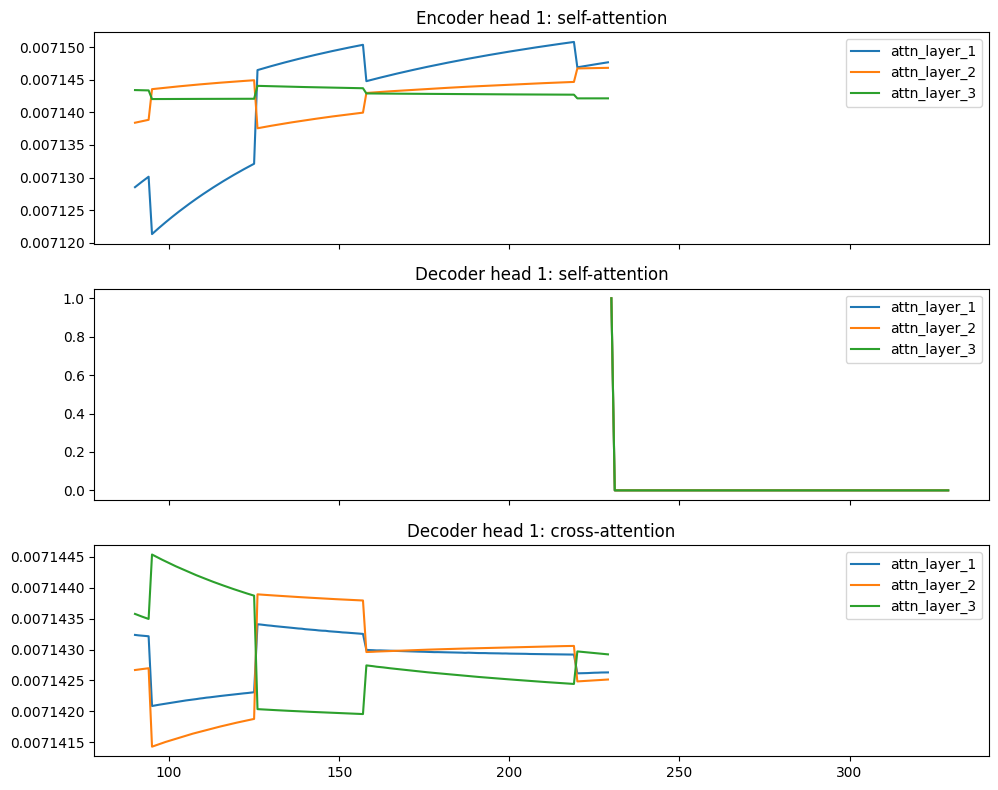

In [143]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

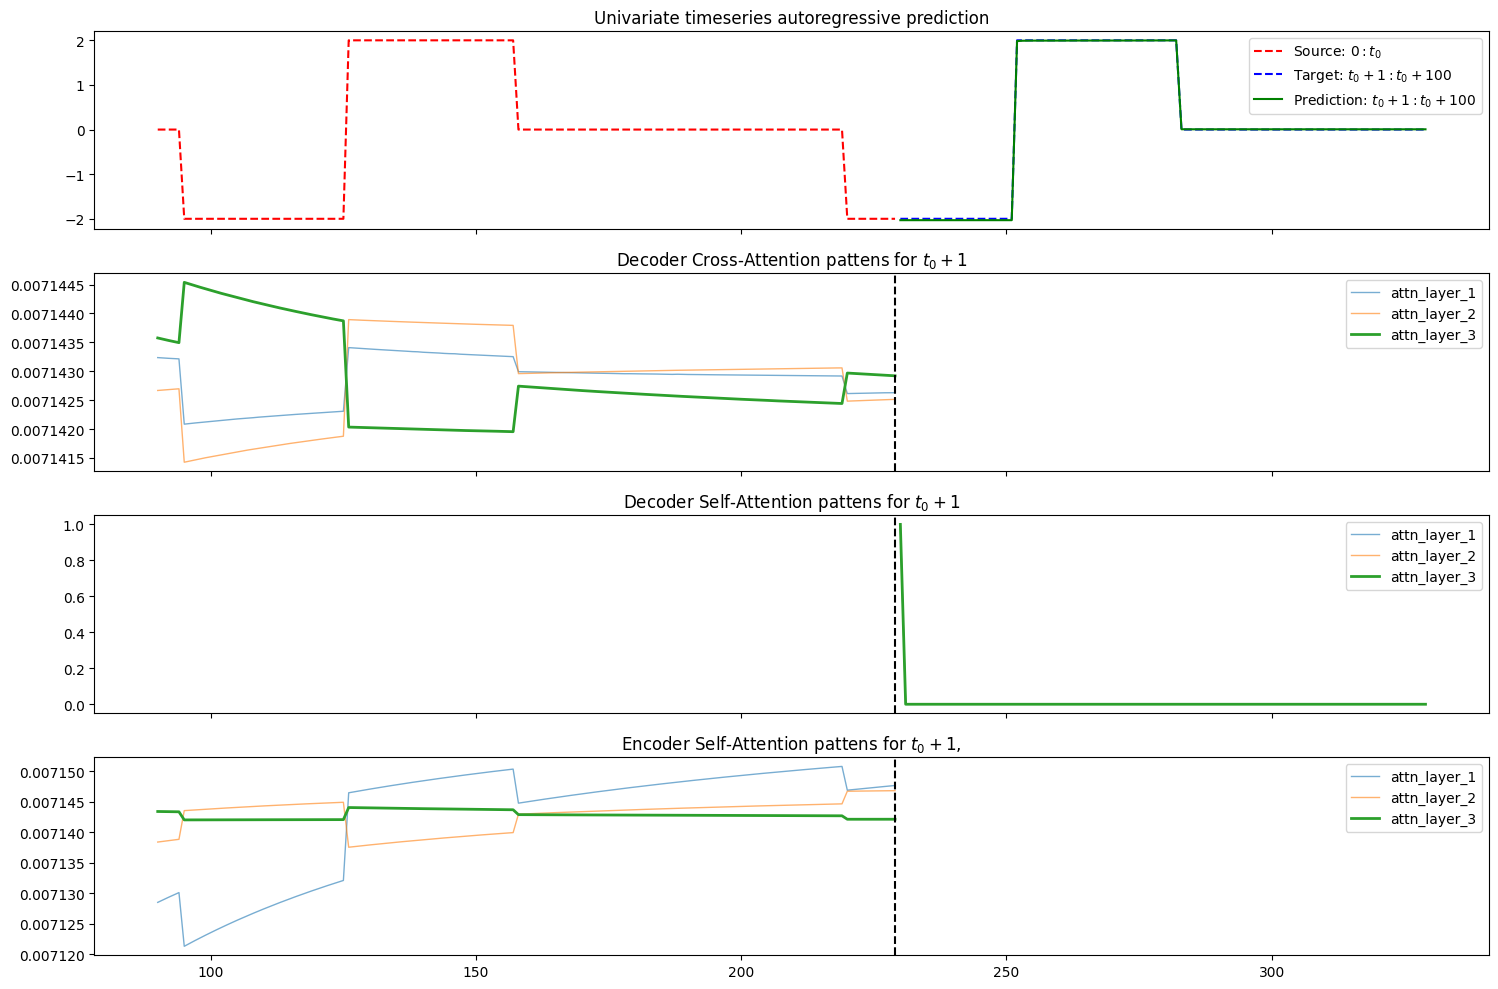

In [145]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
# fig.savefig(f"../../img/baseline_enc_dec/step_multi_enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)

## Experiment 6: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target

In [146]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 50                             # training epochs

### Sine function

#### Dataset splits

In [147]:
dataset = SD.SineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

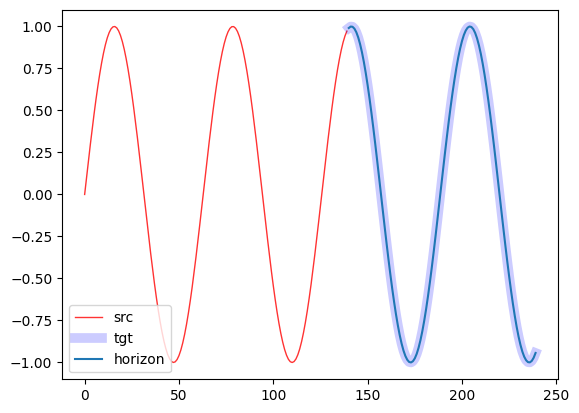

In [148]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [149]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [150]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [151]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.5511	val_loss=0.5030	R_p=['1.0020', '1.0723']
epoch=1	train_loss=0.5043	val_loss=0.5014	R_p=['1.0001', '0.9516']
epoch=2	train_loss=0.5032	val_loss=0.4999	R_p=['0.9999', '1.0048']
epoch=3	train_loss=0.5032	val_loss=0.5004	R_p=['1.0003', '1.0296']
epoch=4	train_loss=0.5021	val_loss=0.5001	R_p=['0.9997', '0.9812']
epoch=5	train_loss=0.5021	val_loss=0.5035	R_p=['1.0023', '1.0774']
epoch=6	train_loss=0.5025	val_loss=0.5004	R_p=['1.0003', '1.0269']
epoch=7	train_loss=0.5016	val_loss=0.5004	R_p=['1.0003', '1.0272']
epoch=8	train_loss=0.5015	val_loss=0.5010	R_p=['1.0008', '1.0431']
epoch=9	train_loss=0.5012	val_loss=0.5000	R_p=['1.0000', '1.0126']
epoch=10	train_loss=0.5011	val_loss=0.5015	R_p=['1.0010', '1.0507']
epoch=11	train_loss=0.5014	val_loss=0.5010	R_p=['1.0000', '0.9587']
epoch=12	train_loss=0.5010	val_loss=0.5029	R_p=['1.0019', '1.0702']
epoch=13	train_loss=0.5012	val_loss=0.5000	R_p=['1.0000', '1.0118']
epoch=14	train_loss=0.5008	val_loss=0.5000	R_p=['0.9997', 

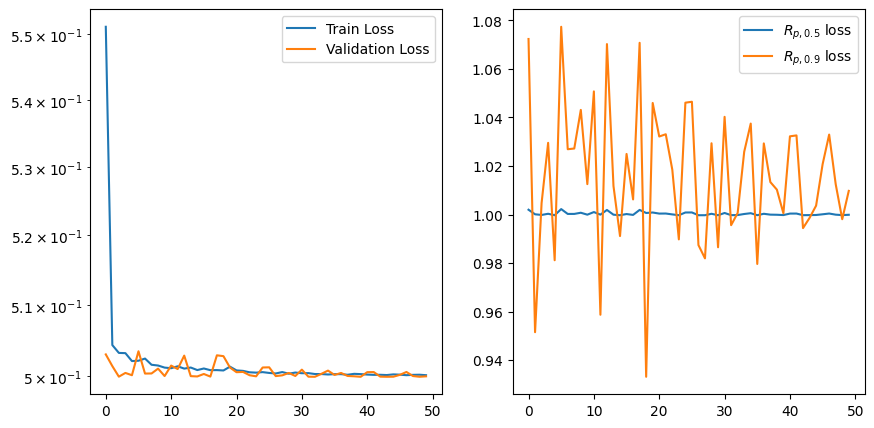

In [152]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [153]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.5000208325386047, tensor([1.0000, 0.9926], device='cuda:0'))

#### Predict

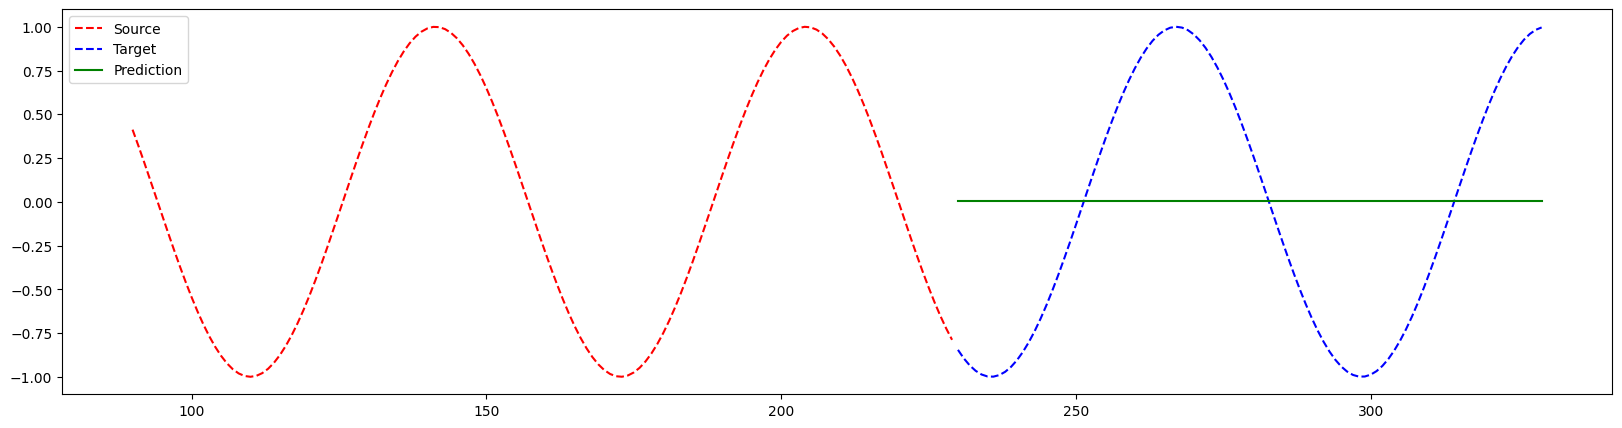

In [154]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [155]:
inspect_step = 0

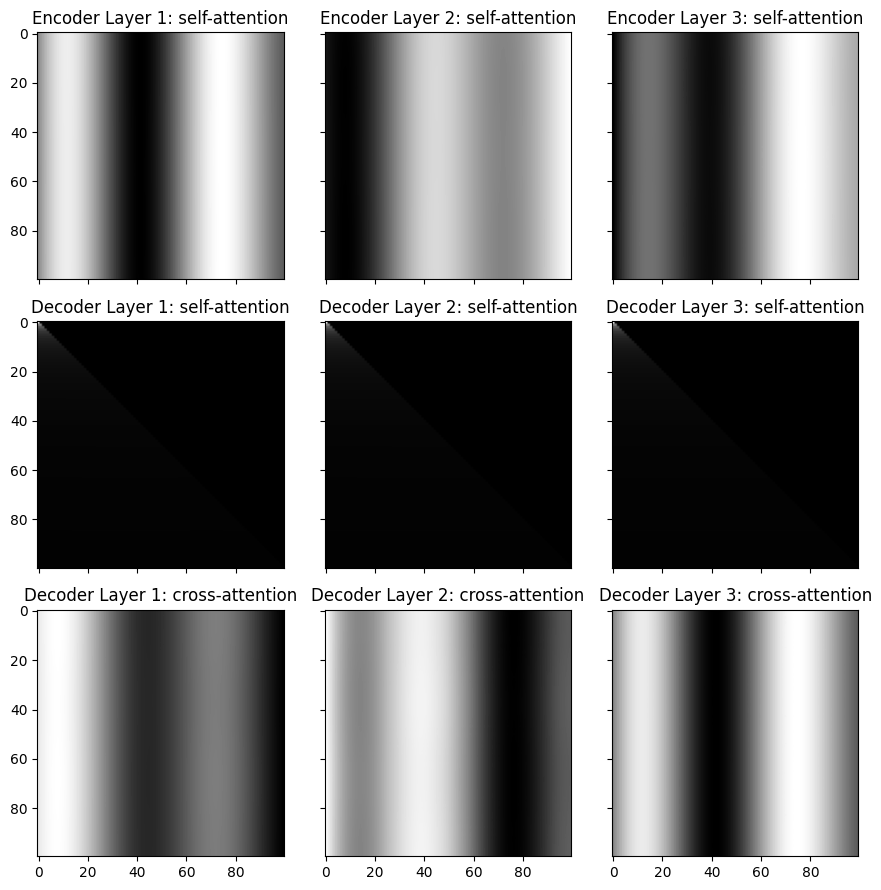

In [156]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

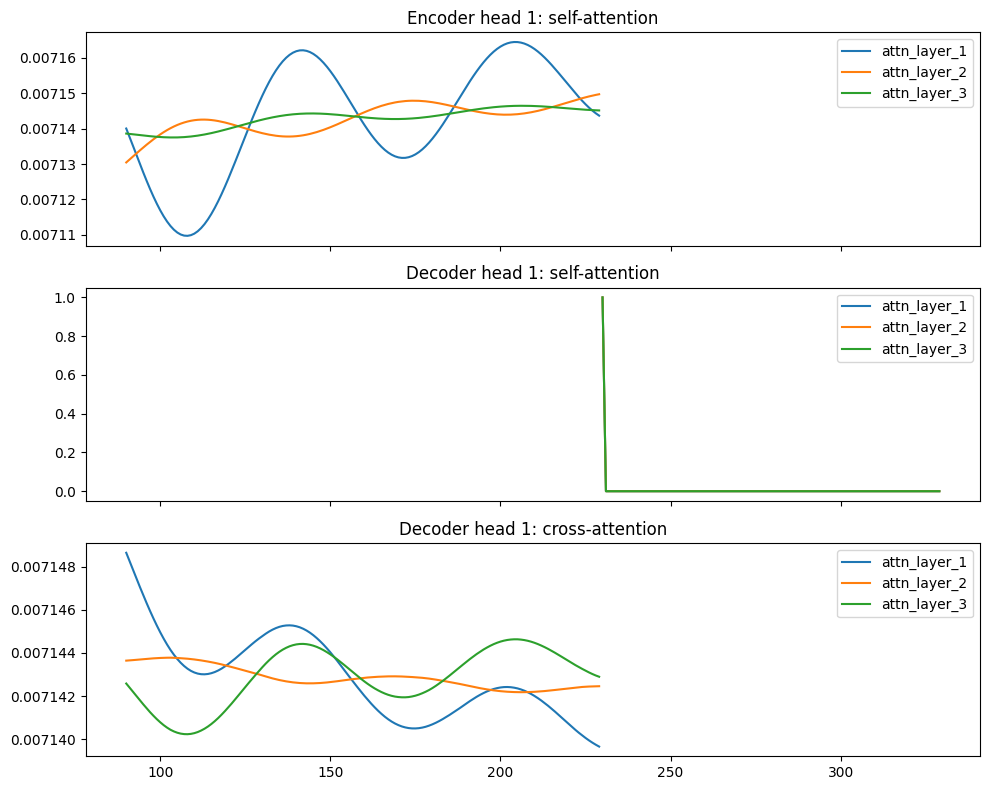

In [157]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

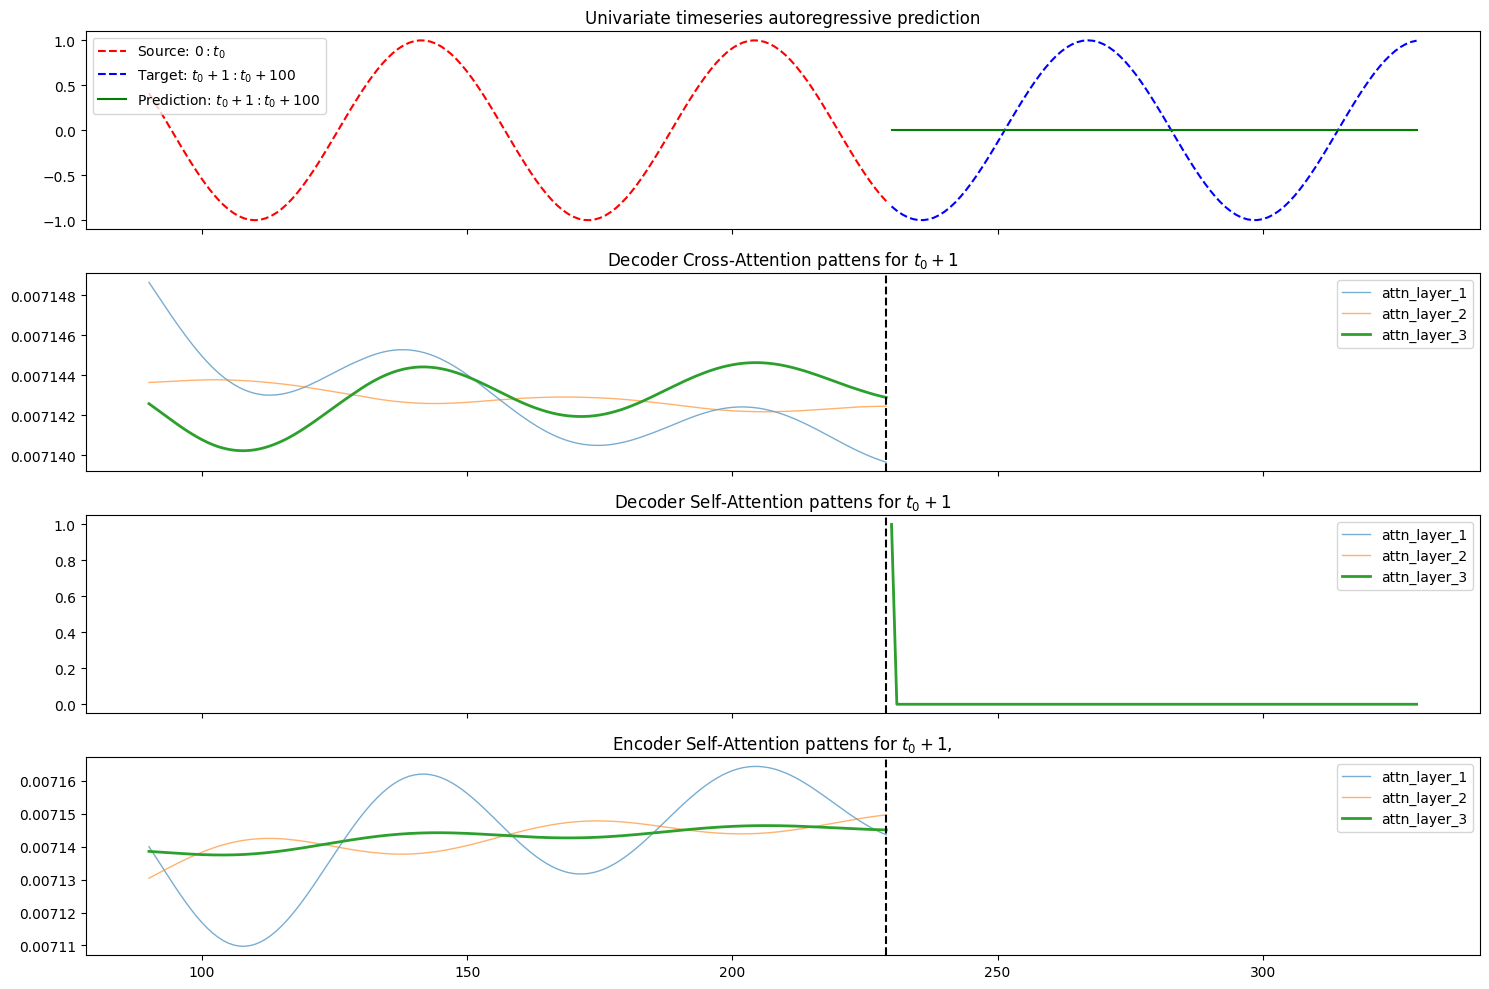

In [159]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
# fig.savefig(f"../../img/baseline_enc_dec/sine_enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)

### Decaying Sine function

#### Dataset splits

In [160]:
dataset = SD.DecayingSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

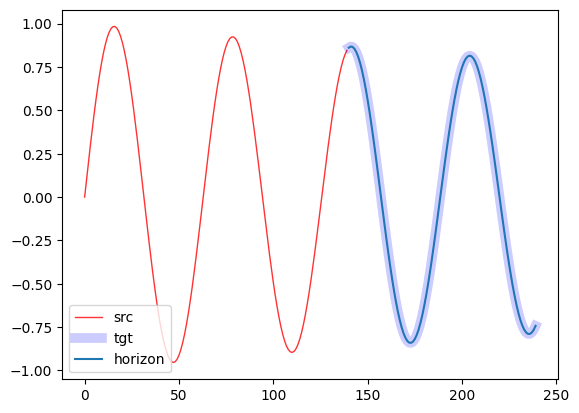

In [161]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [162]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [163]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [164]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.0806	val_loss=0.0266	R_p=['1.0787', '0.9054']
epoch=1	train_loss=0.0305	val_loss=0.0263	R_p=['1.0069', '0.9747']
epoch=2	train_loss=0.0296	val_loss=0.0263	R_p=['1.0073', '1.0639']
epoch=3	train_loss=0.0294	val_loss=0.0264	R_p=['1.0248', '1.1260']
epoch=4	train_loss=0.0294	val_loss=0.0269	R_p=['1.1203', '0.8838']
epoch=5	train_loss=0.0293	val_loss=0.0265	R_p=['1.0576', '0.9195']
epoch=6	train_loss=0.0292	val_loss=0.0263	R_p=['1.0024', '1.0400']
epoch=7	train_loss=0.0291	val_loss=0.0264	R_p=['1.0095', '1.0732']
epoch=8	train_loss=0.0290	val_loss=0.0264	R_p=['1.0390', '0.9340']
epoch=9	train_loss=0.0291	val_loss=0.0267	R_p=['1.0648', '1.2399']
epoch=10	train_loss=0.0290	val_loss=0.0267	R_p=['1.0681', '1.2487']
epoch=11	train_loss=0.0292	val_loss=0.0265	R_p=['1.0444', '1.1840']
epoch=12	train_loss=0.0290	val_loss=0.0265	R_p=['1.0444', '1.1839']
epoch=13	train_loss=0.0290	val_loss=0.0263	R_p=['1.0158', '0.9590']
epoch=14	train_loss=0.0291	val_loss=0.0264	R_p=['1.0175', 

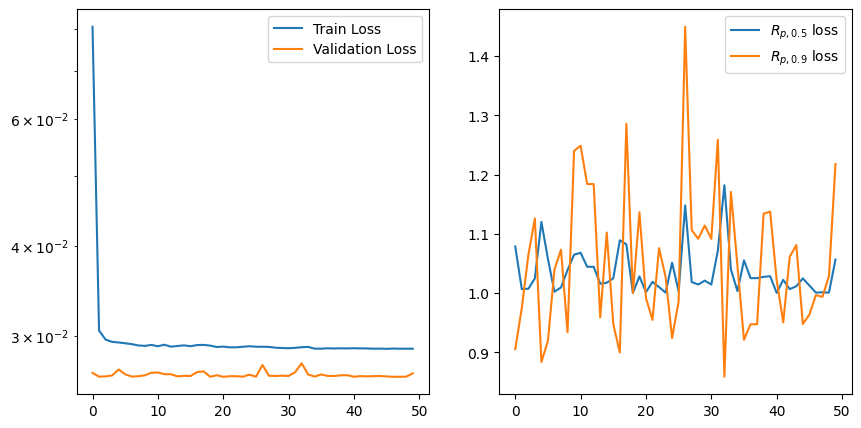

In [165]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [166]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.02957171832025051, tensor([1.0544, 1.2000], device='cuda:0'))

#### Predict

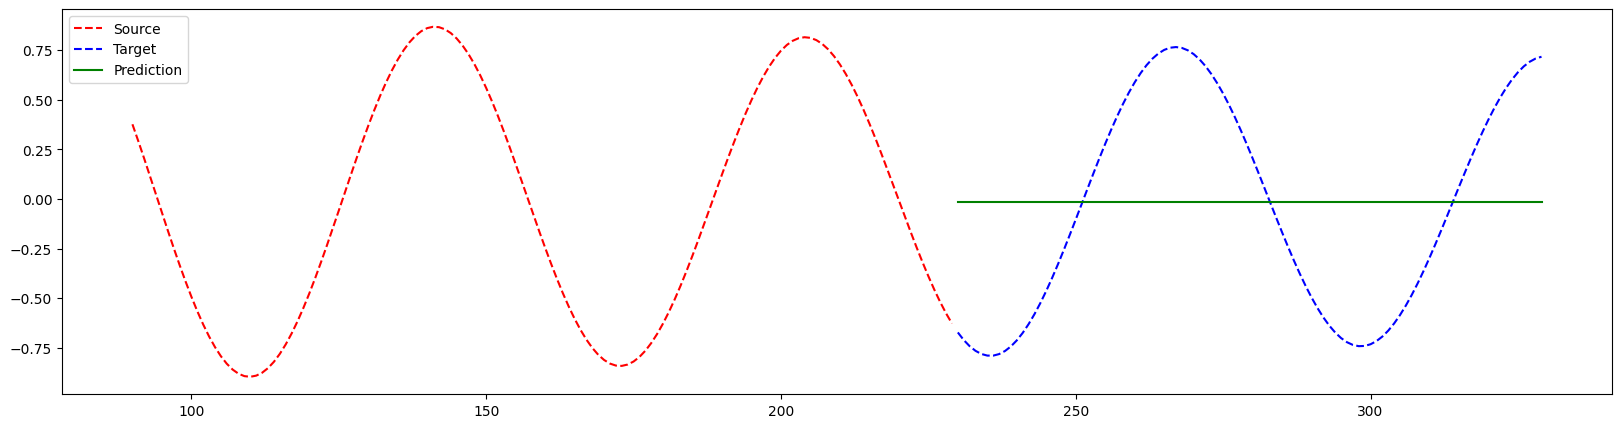

In [167]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [168]:
inspect_step = 0

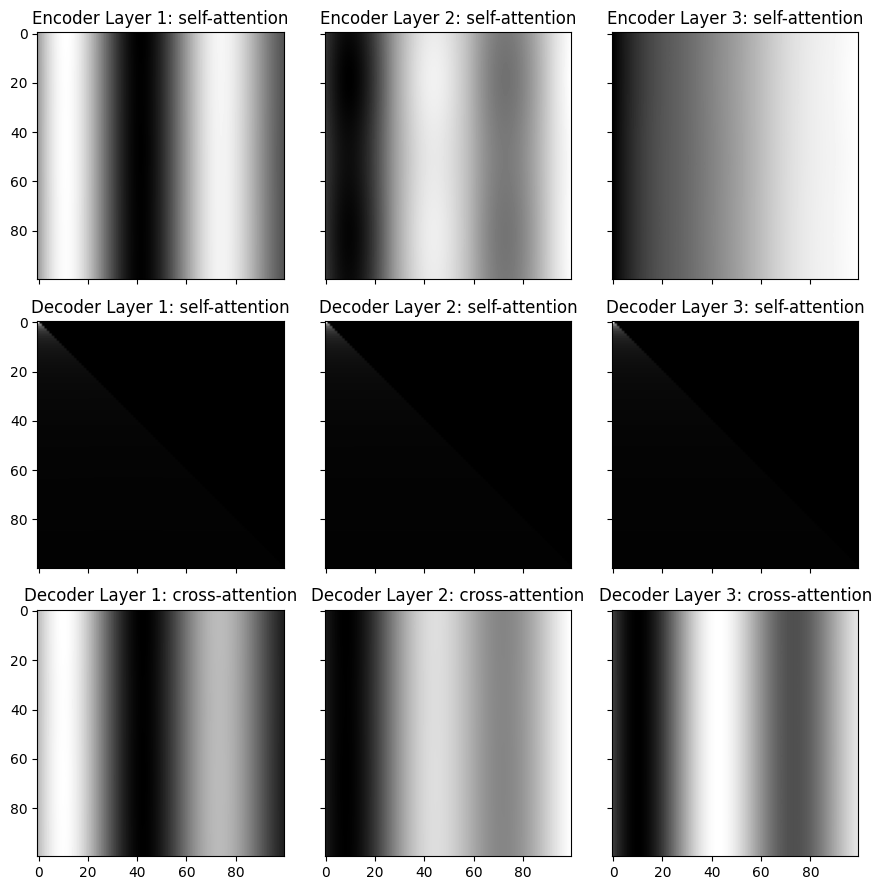

In [169]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

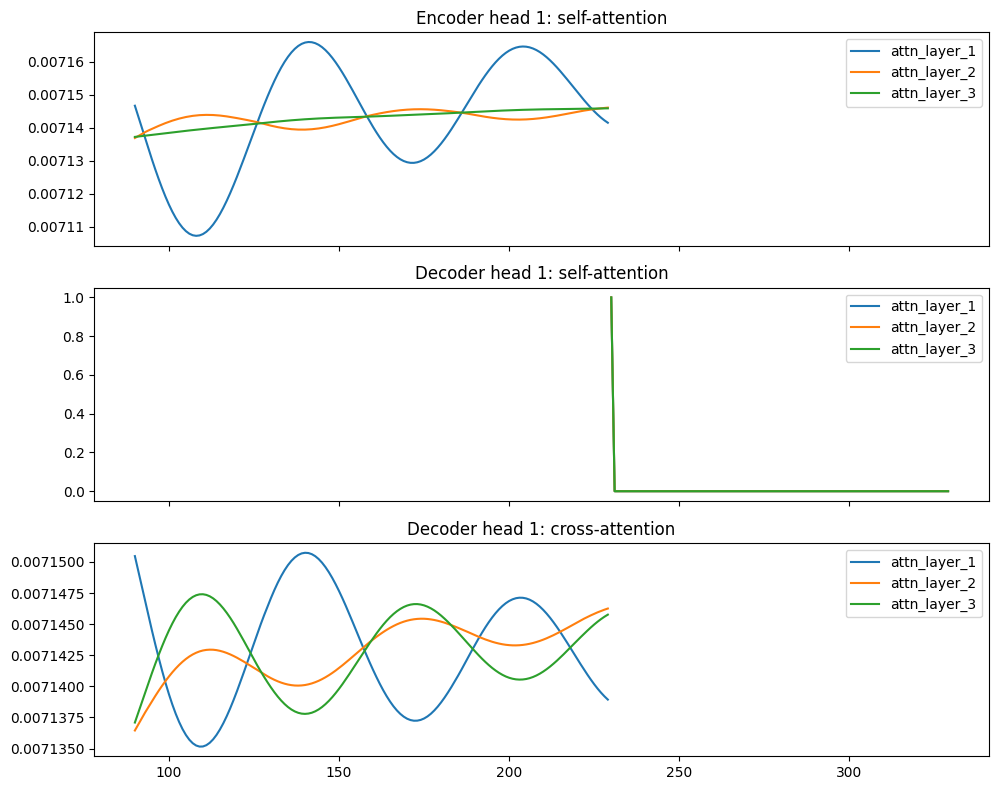

In [170]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

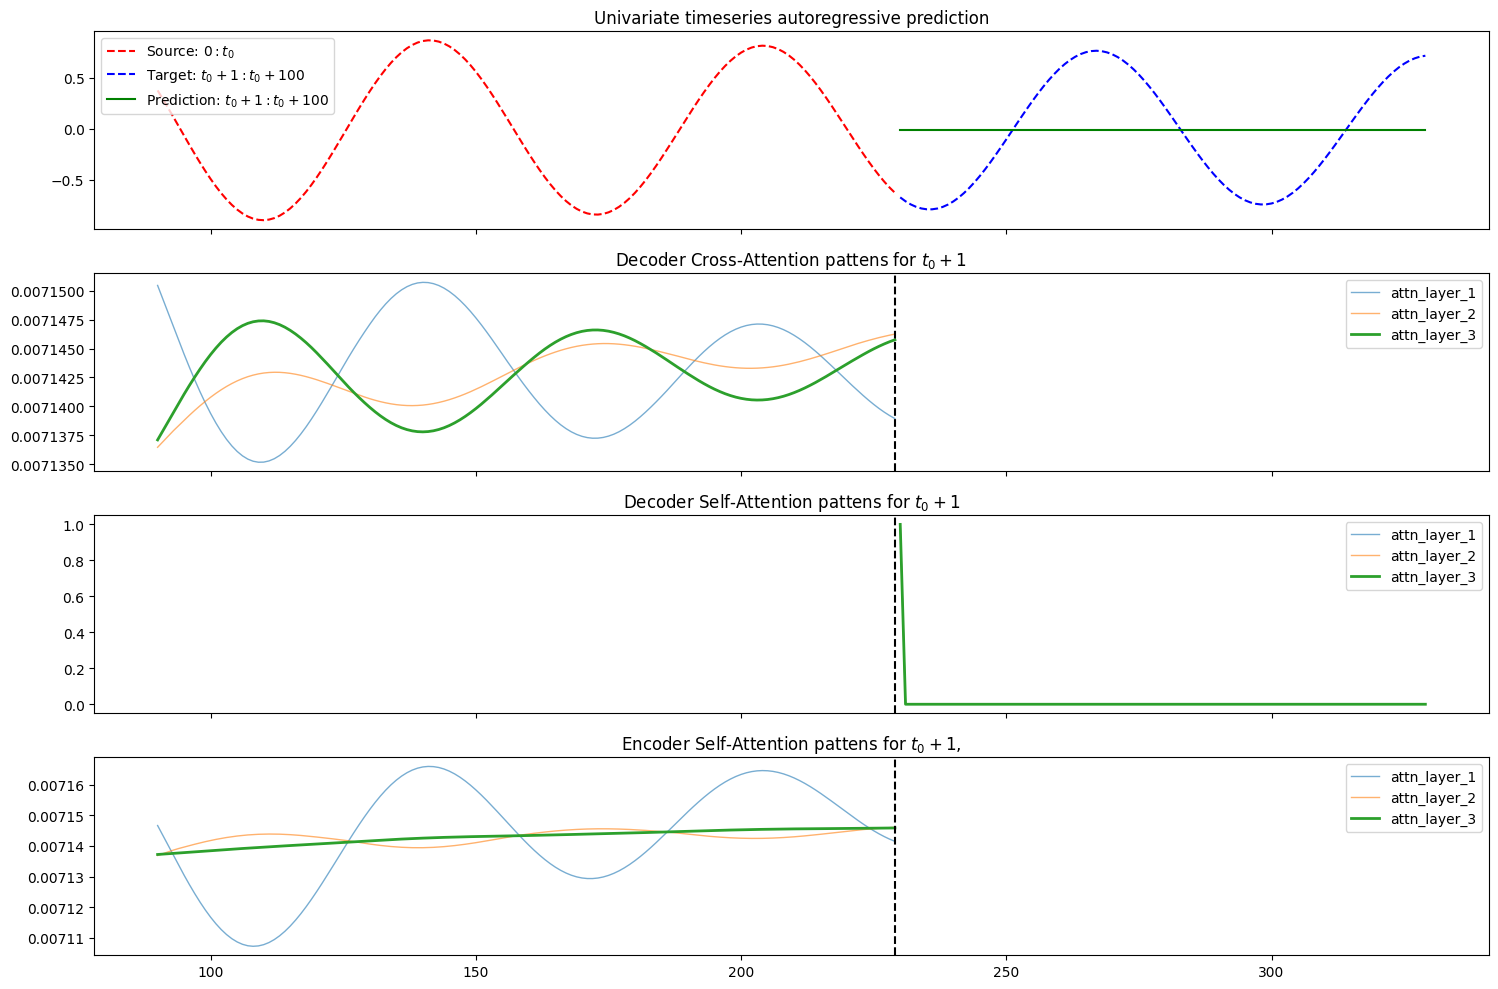

In [172]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
# fig.savefig(f"../../img/baseline_enc_dec/sine_decay_enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)

### Multiple Sine function

#### Dataset splits

In [173]:
dataset = SD.MultipleSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

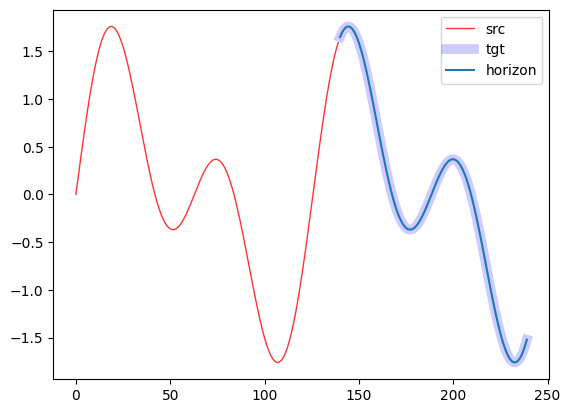

In [174]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [175]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [176]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [177]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=1.0479	val_loss=1.0041	R_p=['1.0006', '1.0382']
epoch=1	train_loss=1.0043	val_loss=1.0034	R_p=['1.0003', '1.0261']
epoch=2	train_loss=1.0026	val_loss=1.0027	R_p=['1.0000', '0.9959']
epoch=3	train_loss=1.0033	val_loss=1.0030	R_p=['1.0001', '1.0180']
epoch=4	train_loss=1.0016	val_loss=1.0104	R_p=['1.0039', '1.0922']
epoch=5	train_loss=1.0016	val_loss=1.0027	R_p=['1.0000', '0.9956']
epoch=6	train_loss=1.0024	val_loss=1.0061	R_p=['1.0017', '1.0604']
epoch=7	train_loss=1.0013	val_loss=1.0139	R_p=['1.0057', '1.1119']
epoch=8	train_loss=1.0013	val_loss=1.0054	R_p=['1.0016', '0.9497']
epoch=9	train_loss=1.0005	val_loss=1.0031	R_p=['1.0002', '1.0208']
epoch=10	train_loss=1.0015	val_loss=1.0032	R_p=['1.0002', '1.0218']
epoch=11	train_loss=1.0005	val_loss=1.0059	R_p=['1.0016', '1.0587']
epoch=12	train_loss=1.0004	val_loss=1.0052	R_p=['1.0015', '0.9516']
epoch=13	train_loss=1.0014	val_loss=1.0032	R_p=['1.0002', '1.0230']
epoch=14	train_loss=1.0005	val_loss=1.0048	R_p=['1.0010', 

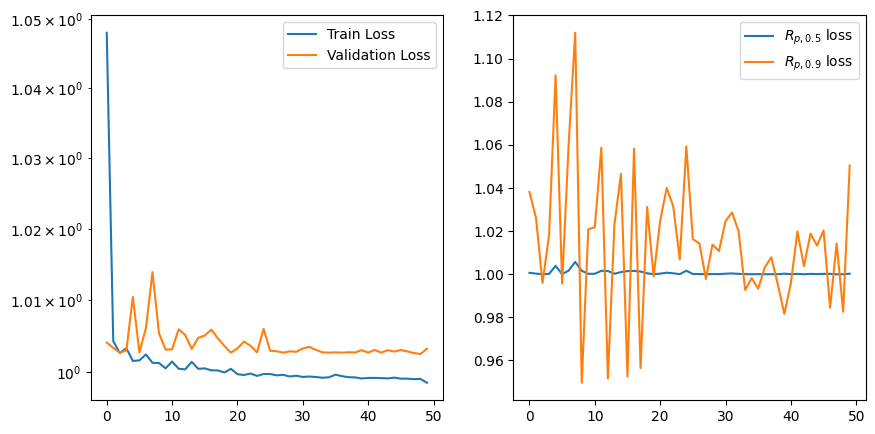

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [179]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(1.0084098854064942, tensor([0.9998, 1.0383], device='cuda:0'))

#### Predict

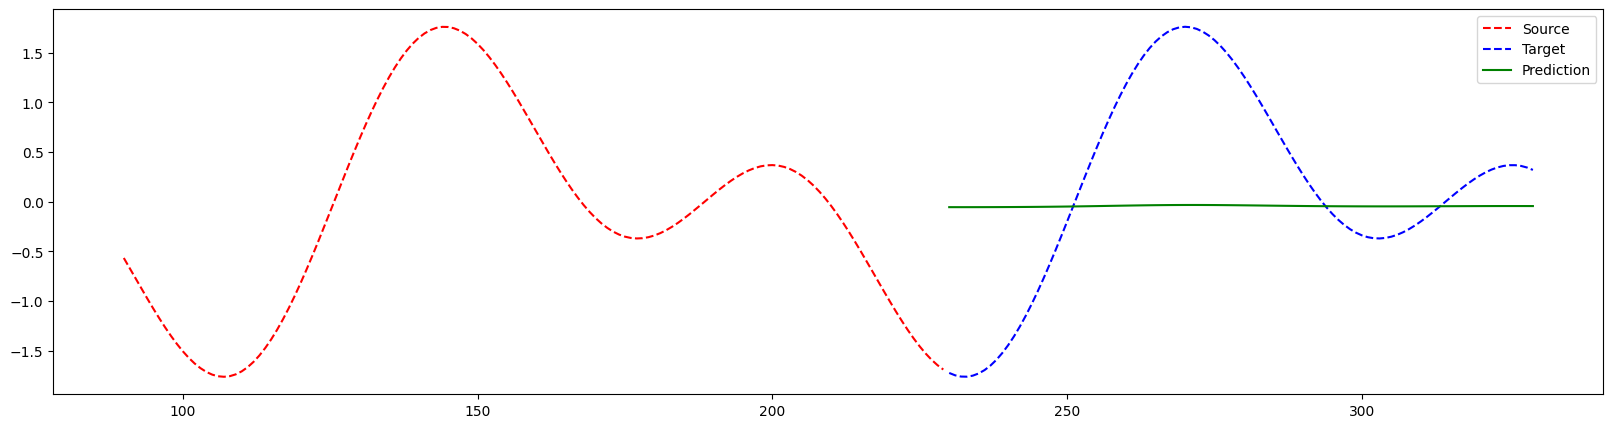

In [180]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [181]:
inspect_step = 0

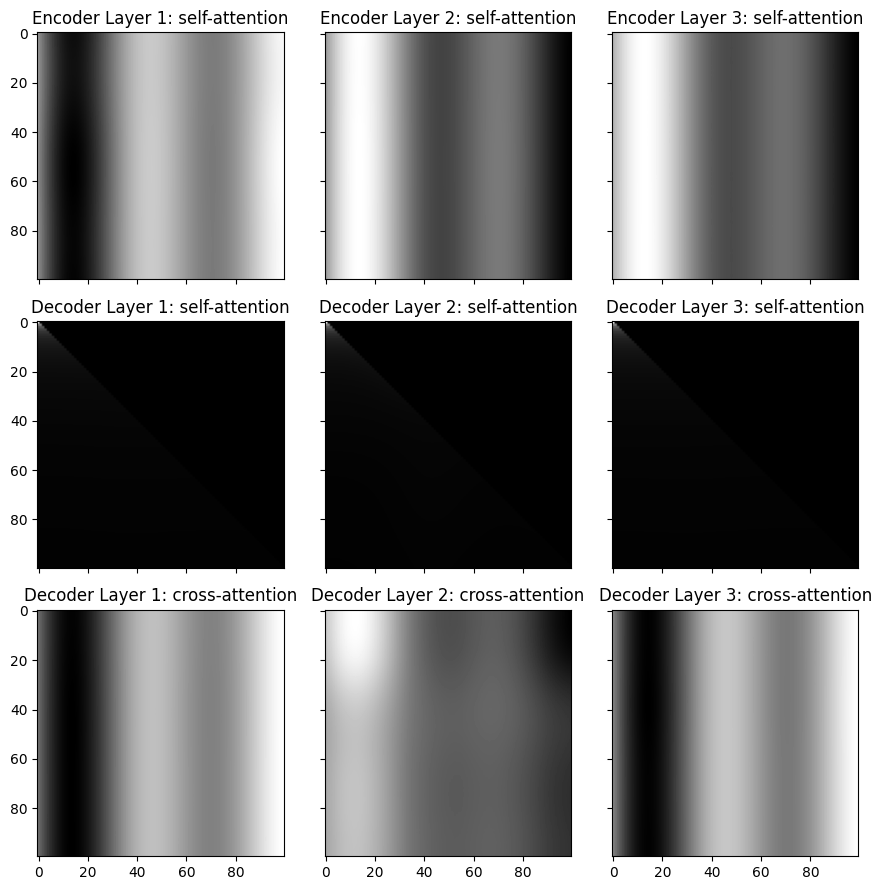

In [182]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

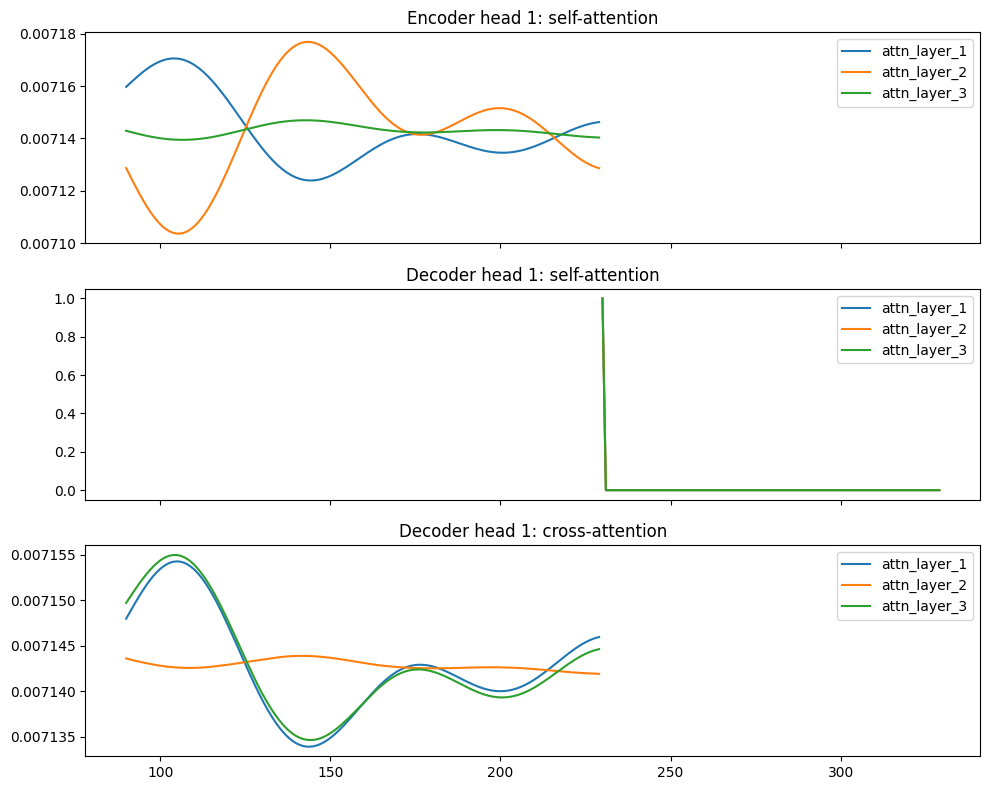

In [183]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

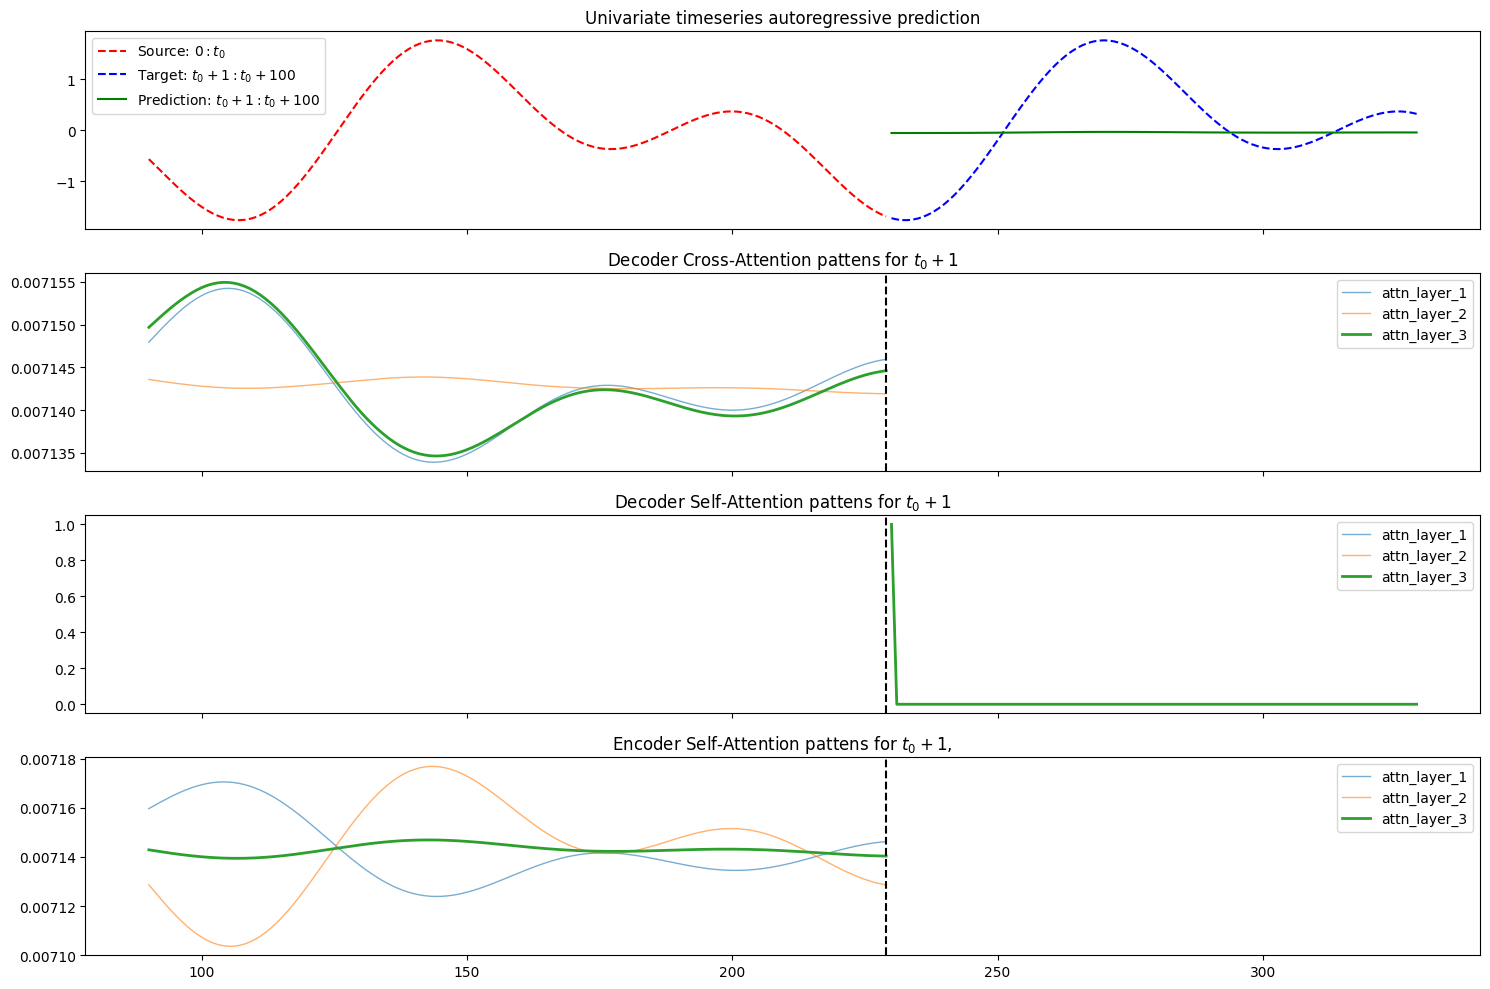

In [184]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
fig.savefig(f"../../img/baseline_enc_dec/sine_multi_enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)

## Experiment 7: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

In [185]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                              # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

emb_size = 32                           # size of transformer block embedding (d_model) 
n_hidden = 64                           # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = 1024                     # point-wise feed forward net hidden dimensions
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
lr = 0.0005                              # initial learning rate

ps = [0.5, 0.9]                         # rho_quantile loss probs
lr_step_size = 10                       # every 30 steps decrease learning rate by gamma
lr_gamma = 0.9                          # learning rate decrease rate

EPOCHS = 50                             # training epochs

### Sawtooth function

#### Dataset splits

In [186]:
dataset = SD.SawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, p=10, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

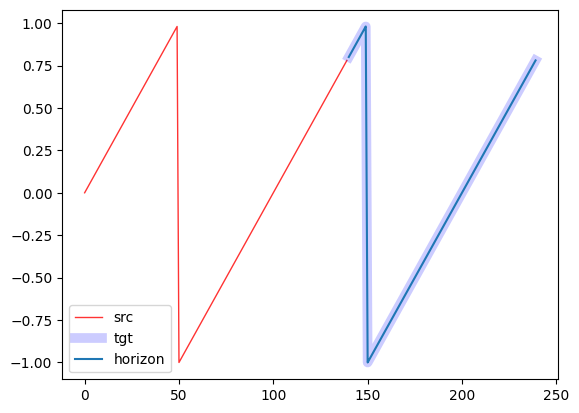

In [187]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [188]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [189]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [190]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.3869	val_loss=0.3333	R_p=['1.0000', '0.9988']
epoch=1	train_loss=0.3355	val_loss=0.3335	R_p=['1.0002', '1.0227']
epoch=2	train_loss=0.3347	val_loss=0.3333	R_p=['1.0000', '1.0098']
epoch=3	train_loss=0.3344	val_loss=0.3334	R_p=['1.0000', '0.9827']
epoch=4	train_loss=0.3343	val_loss=0.3333	R_p=['1.0000', '1.0043']
epoch=5	train_loss=0.3340	val_loss=0.3333	R_p=['1.0000', '0.9941']
epoch=6	train_loss=0.3339	val_loss=0.3333	R_p=['1.0000', '0.9988']
epoch=7	train_loss=0.3338	val_loss=0.3333	R_p=['1.0000', '0.9911']
epoch=8	train_loss=0.3338	val_loss=0.3334	R_p=['1.0000', '0.9879']
epoch=9	train_loss=0.3338	val_loss=0.3333	R_p=['1.0000', '1.0009']
epoch=10	train_loss=0.3337	val_loss=0.3334	R_p=['1.0000', '0.9840']
epoch=11	train_loss=0.3337	val_loss=0.3333	R_p=['1.0000', '0.9948']
epoch=12	train_loss=0.3337	val_loss=0.3333	R_p=['1.0000', '0.9956']
epoch=13	train_loss=0.3337	val_loss=0.3334	R_p=['1.0000', '1.0150']
epoch=14	train_loss=0.3337	val_loss=0.3333	R_p=['1.0000', 

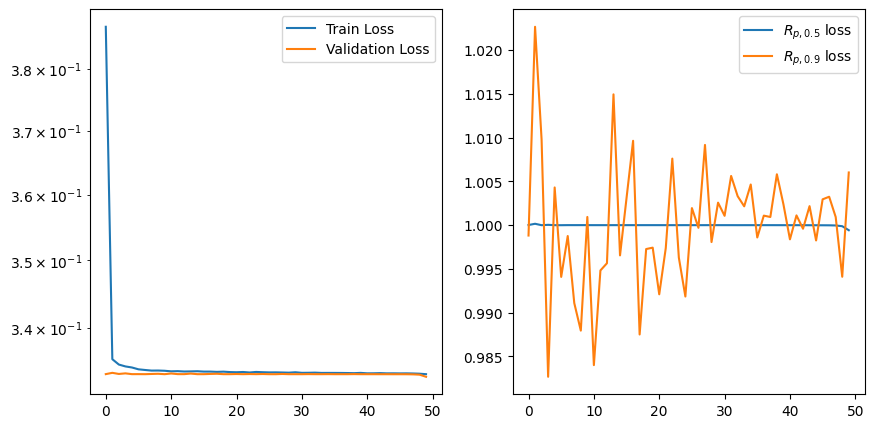

In [191]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [192]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.3329213845729828, tensor([0.9994, 1.0060], device='cuda:0'))

#### Predict

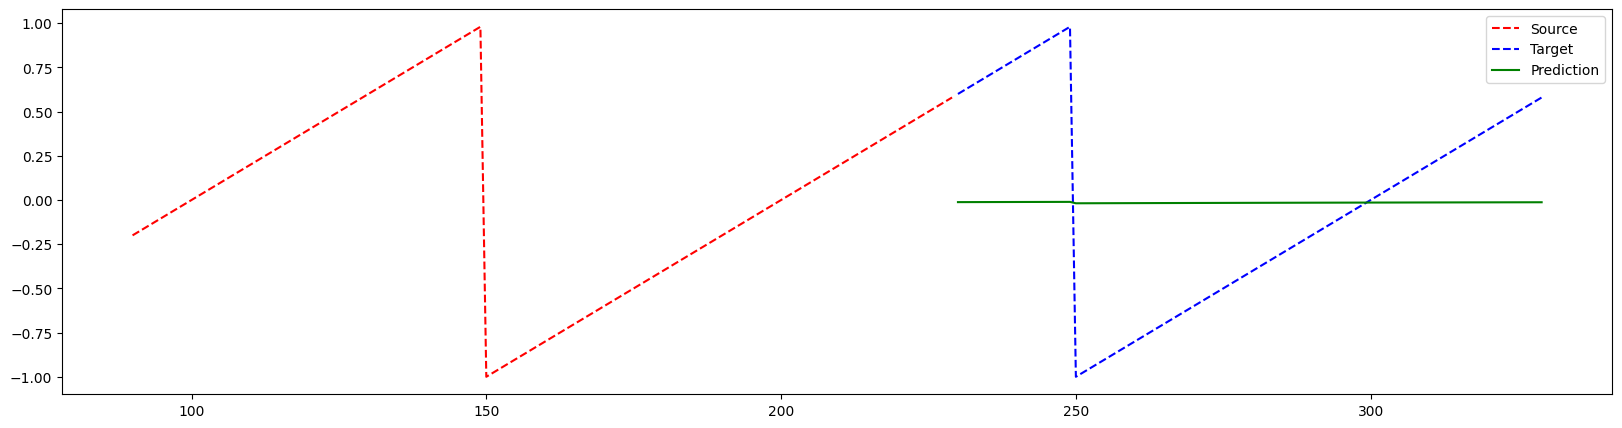

In [193]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [194]:
inspect_step = 0

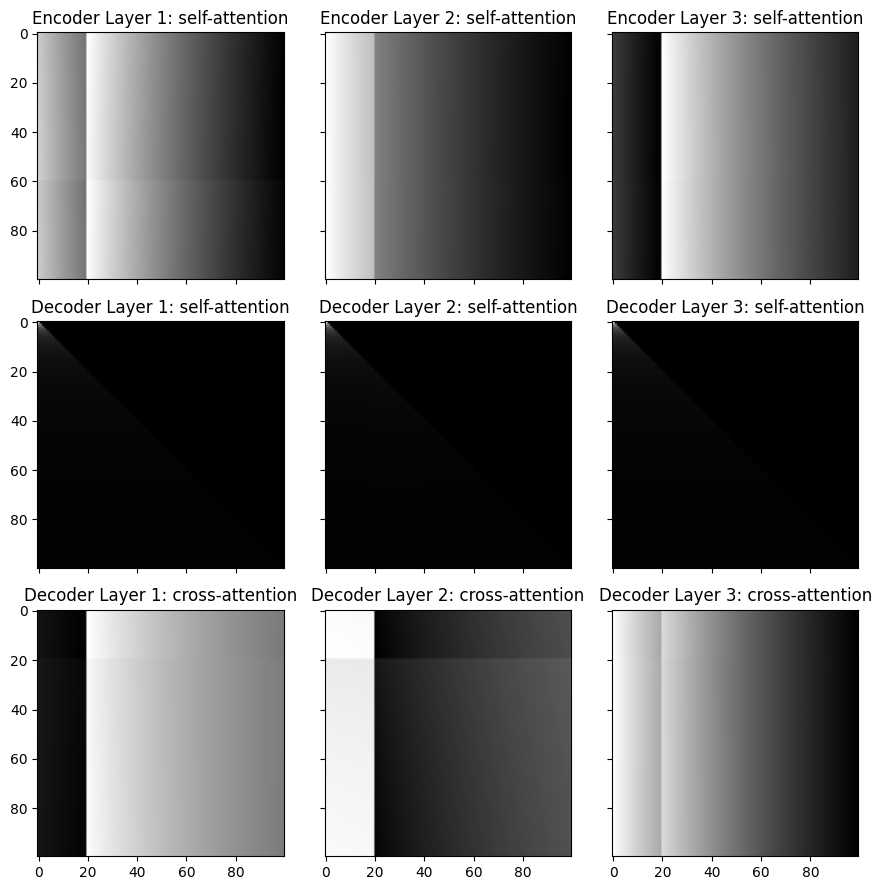

In [195]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

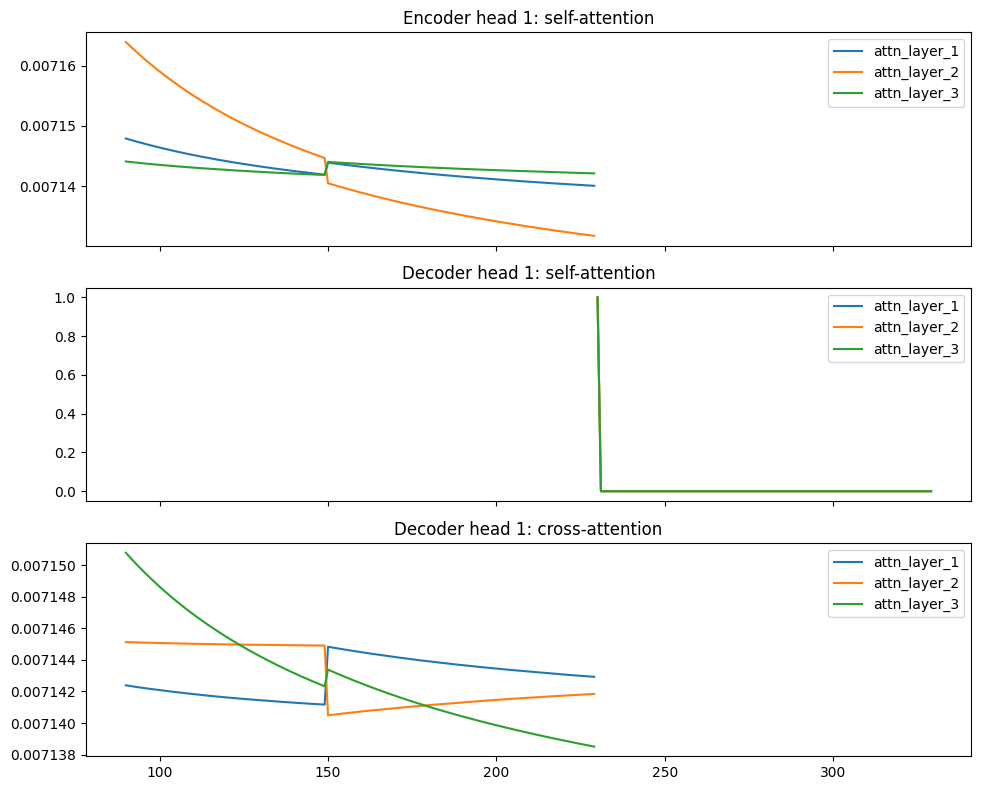

In [196]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

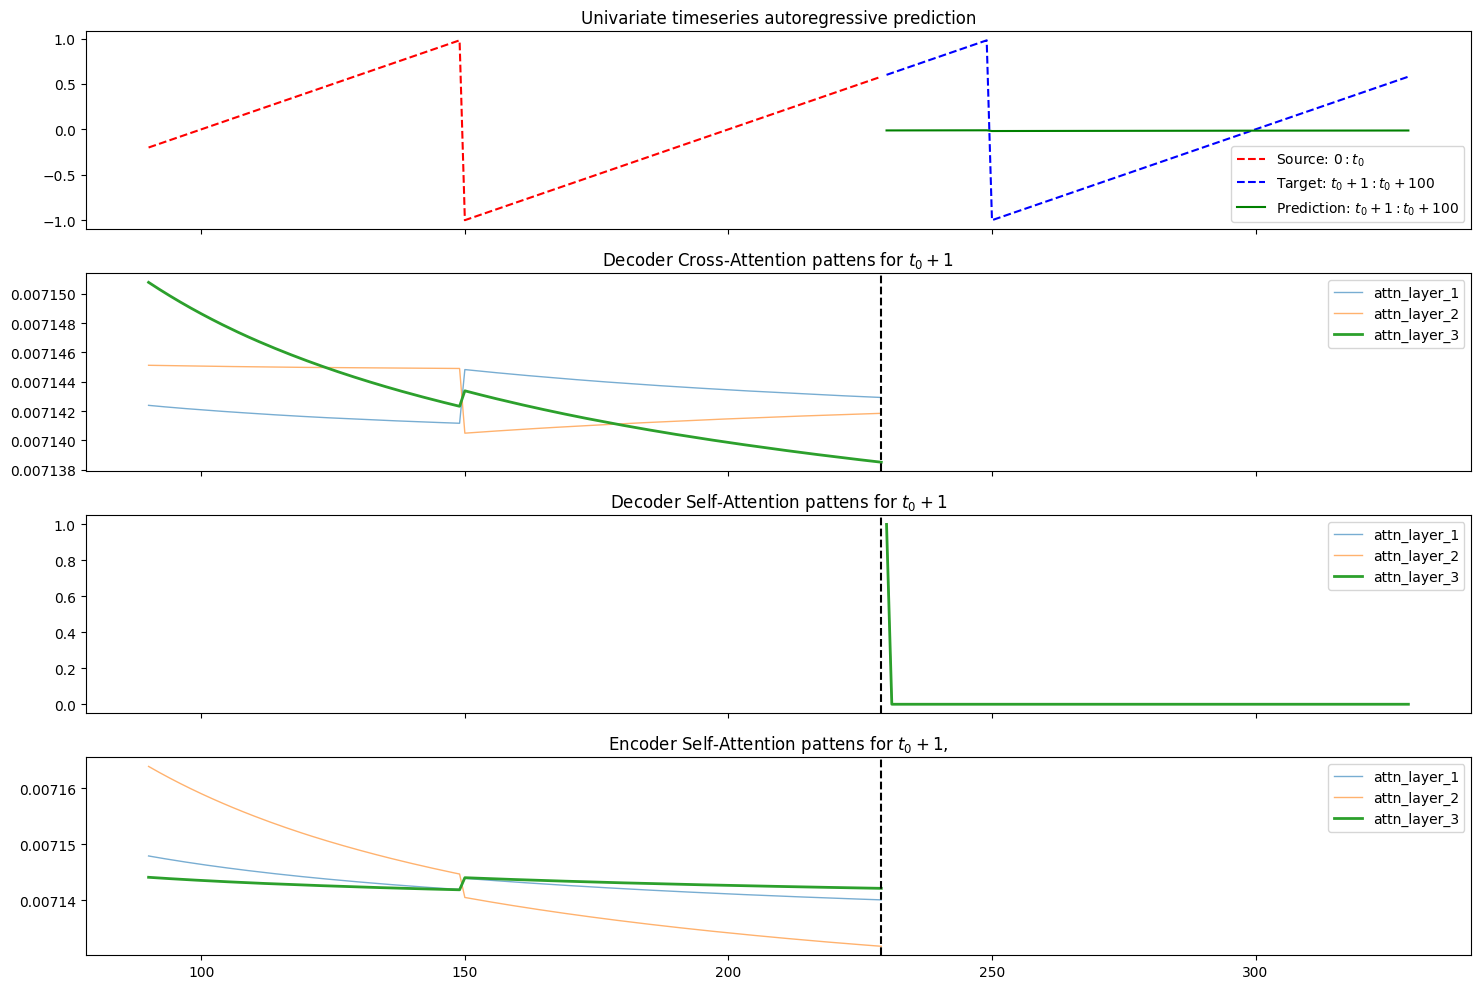

In [198]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
fig.savefig(f"../../img/baseline_enc_dec/sawtooth_enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)

### Decaying Sawtooth function

#### Dataset splits

In [199]:
dataset = SD.DecayingSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, p=10,  mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

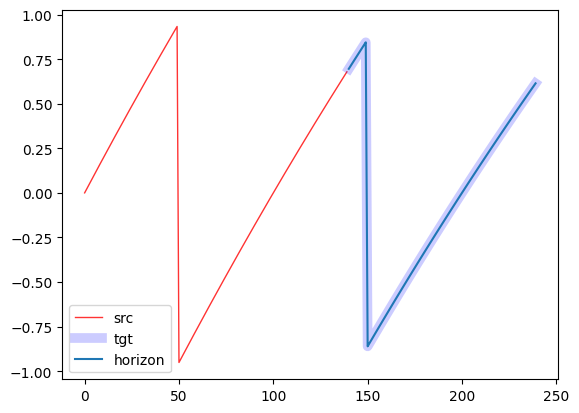

In [200]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [201]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [202]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [203]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.0804	val_loss=0.0212	R_p=['1.0458', '1.1531']
epoch=1	train_loss=0.0214	val_loss=0.0211	R_p=['1.0246', '1.0915']
epoch=2	train_loss=0.0201	val_loss=0.0211	R_p=['1.0224', '1.0846']
epoch=3	train_loss=0.0199	val_loss=0.0211	R_p=['1.0068', '1.0309']
epoch=4	train_loss=0.0198	val_loss=0.0211	R_p=['1.0166', '1.0659']
epoch=5	train_loss=0.0197	val_loss=0.0212	R_p=['1.0430', '1.1454']
epoch=6	train_loss=0.0197	val_loss=0.0211	R_p=['1.0031', '1.0146']
epoch=7	train_loss=0.0196	val_loss=0.0212	R_p=['1.0394', '1.1353']
epoch=8	train_loss=0.0196	val_loss=0.0211	R_p=['1.0288', '1.1042']
epoch=9	train_loss=0.0196	val_loss=0.0211	R_p=['1.0005', '0.9767']
epoch=10	train_loss=0.0196	val_loss=0.0211	R_p=['1.0180', '1.0705']
epoch=11	train_loss=0.0196	val_loss=0.0211	R_p=['1.0157', '1.0633']
epoch=12	train_loss=0.0196	val_loss=0.0211	R_p=['1.0004', '0.9950']
epoch=13	train_loss=0.0196	val_loss=0.0211	R_p=['1.0149', '0.9423']
epoch=14	train_loss=0.0195	val_loss=0.0211	R_p=['1.0006', 

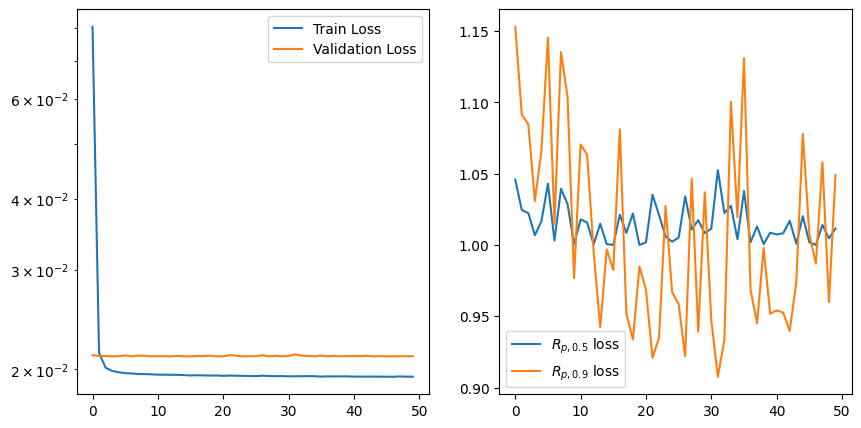

In [204]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [205]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.016699627324938775, tensor([1.0123, 1.0546], device='cuda:0'))

#### Predict

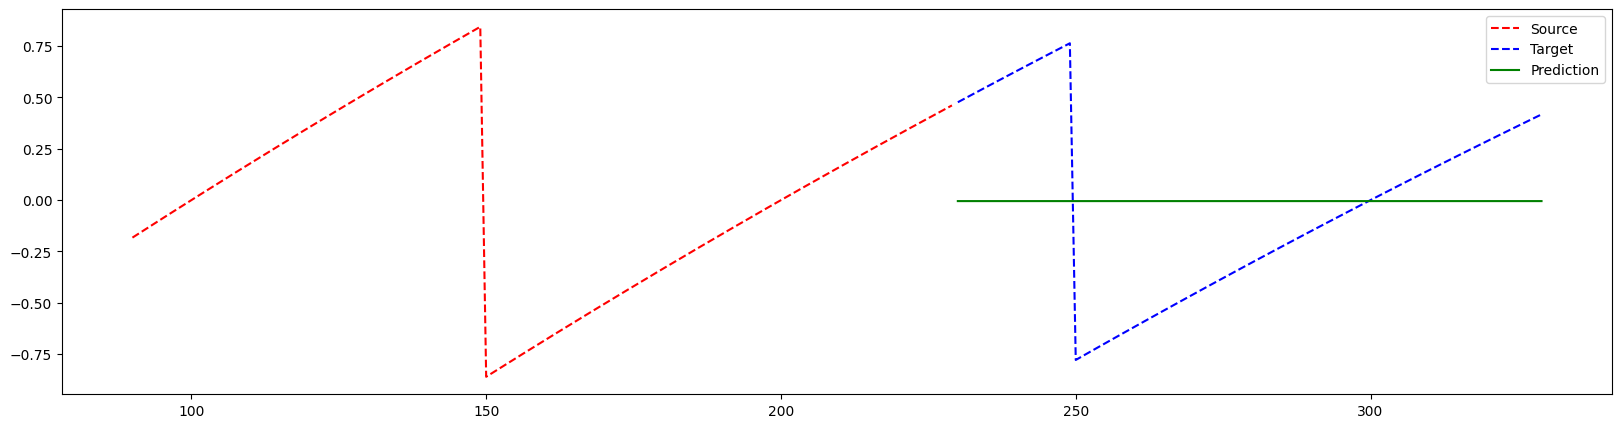

In [206]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [207]:
inspect_step = 0

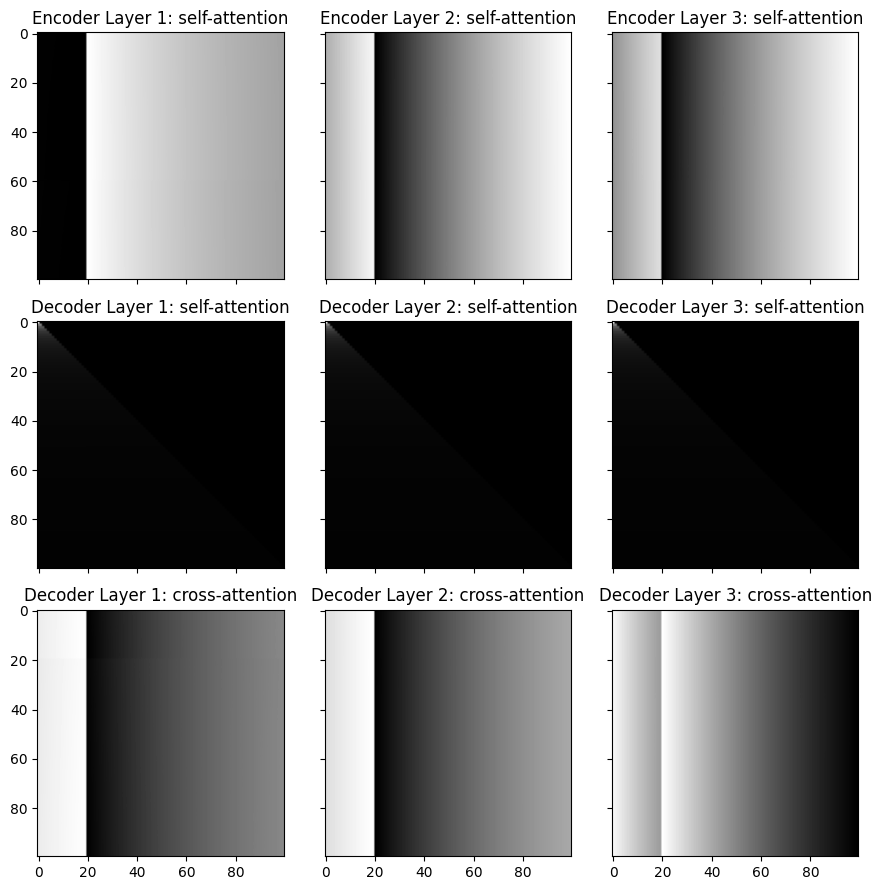

In [208]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

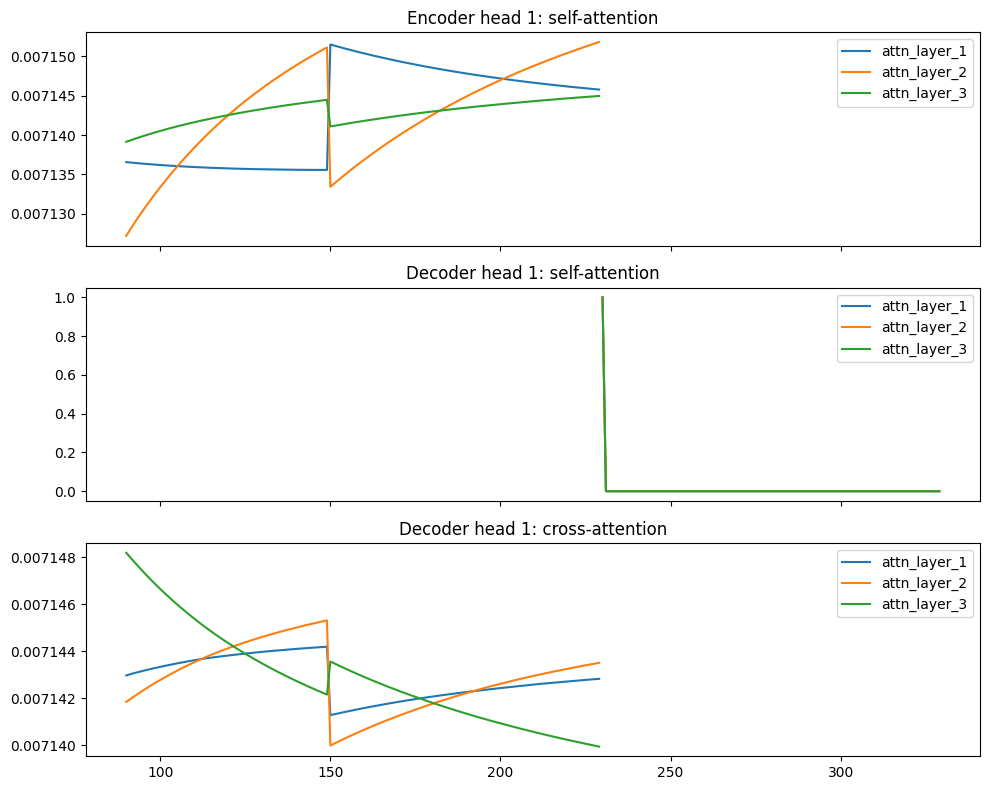

In [209]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

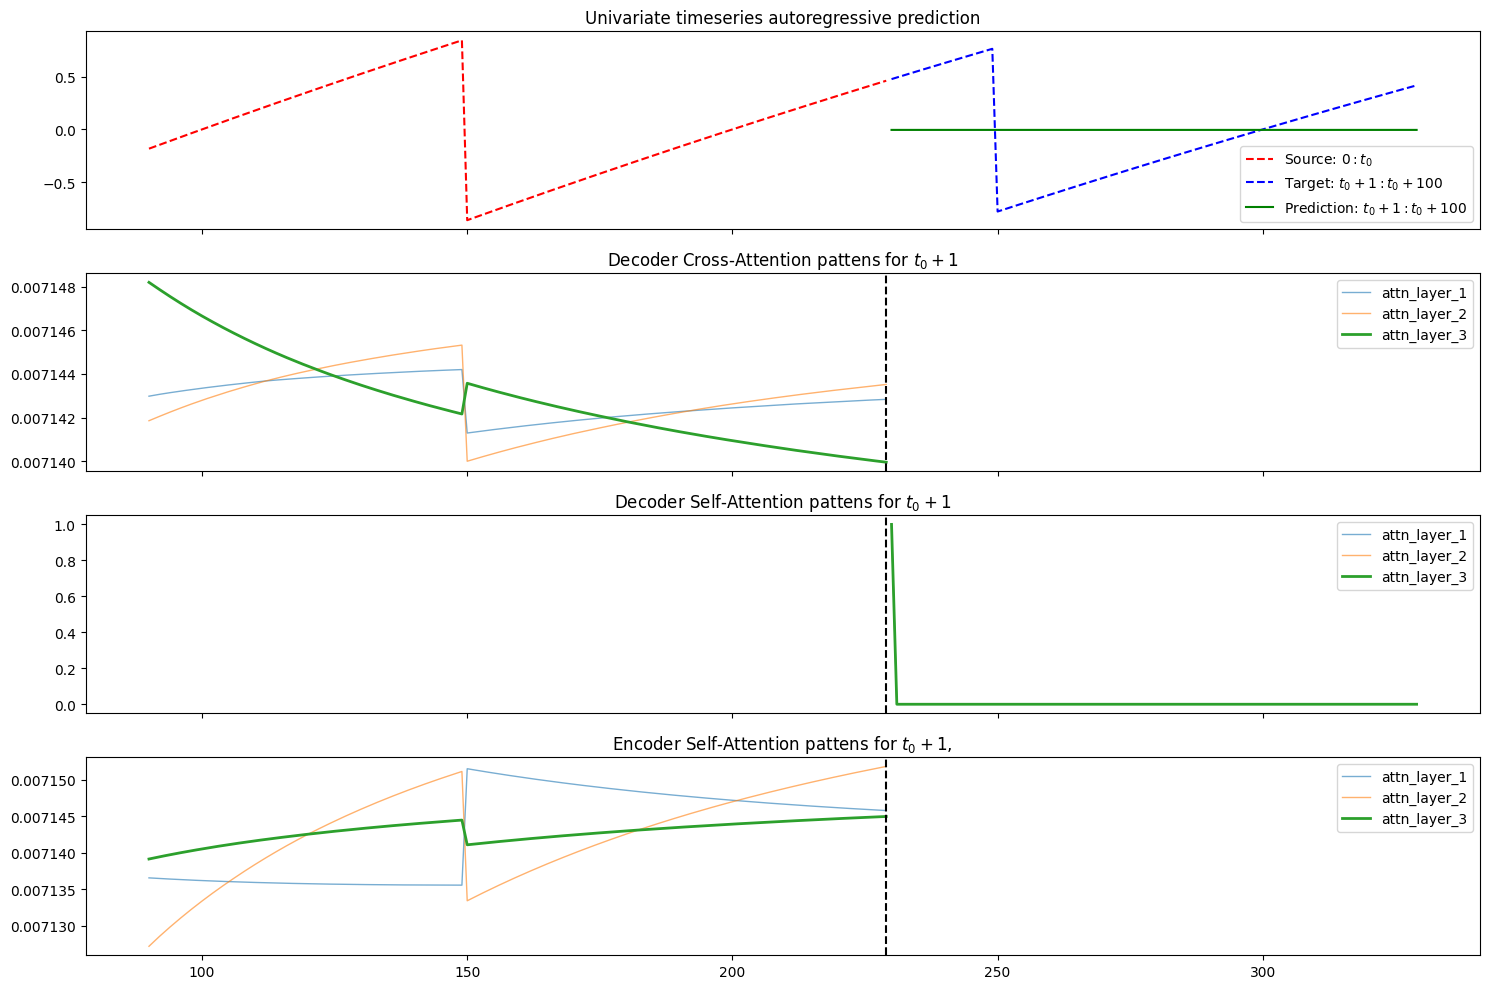

In [210]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
fig.savefig(f"../../img/baseline_enc_dec/sawtooth_decay_enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)

### Multiple Sawtooth function

#### Dataset splits

In [211]:
dataset = SD.MultipleSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, p=5, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 1]),
 torch.Size([100, 1]),
 torch.Size([100, 1]))

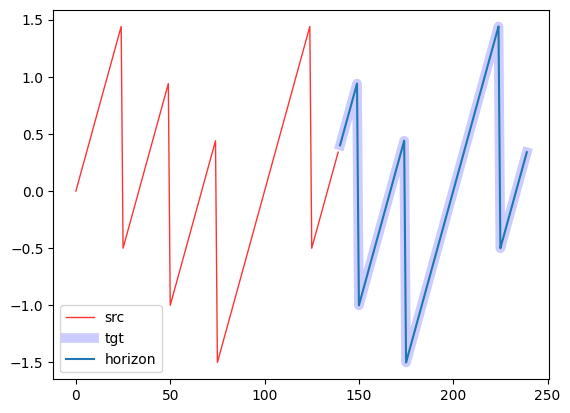

In [212]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

#### Training setup

In [213]:
model = PointEncoderDecoderTransformer(
    enc_d_in=n_timeseries+1, 
    dec_d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
test_history = []
R_ps = []

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [214]:
dataset.mask = dataset.mask[:shift, :shift]
dataset.mask.shape

torch.Size([100, 100])

In [215]:
for epoch in range(EPOCHS):
    
    train_history.append(train_step_enc_dec(model, criterion, train_dl, optimizer, dataset.mask, shift, device))
    val_loss, r_ps = val_step_enc_dec(model, criterion, val_dl, ps, dataset.mask, shift, device)
    
    val_history.append(val_loss)
    R_ps.append(r_ps.tolist())
    
    scheduler.step()
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    print(f"{epoch=}\ttrain_loss={train_history[-1]:.4f}\tval_loss={val_history[-1]:.4f}\tR_p={R_ps_formatted}")

epoch=0	train_loss=0.5334	val_loss=0.5000	R_p=['0.9995', '0.9777']
epoch=1	train_loss=0.5021	val_loss=0.4997	R_p=['0.9993', '1.0079']
epoch=2	train_loss=0.5013	val_loss=0.4997	R_p=['0.9993', '0.9916']
epoch=3	train_loss=0.5008	val_loss=0.4998	R_p=['0.9993', '0.9885']
epoch=4	train_loss=0.5008	val_loss=0.4997	R_p=['0.9993', '0.9996']
epoch=5	train_loss=0.5006	val_loss=0.4997	R_p=['0.9993', '1.0061']
epoch=6	train_loss=0.5005	val_loss=0.4997	R_p=['0.9993', '0.9945']
epoch=7	train_loss=0.5004	val_loss=0.4997	R_p=['0.9993', '1.0016']
epoch=8	train_loss=0.5003	val_loss=0.4997	R_p=['0.9993', '0.9991']
epoch=9	train_loss=0.5004	val_loss=0.4997	R_p=['0.9993', '0.9945']
epoch=10	train_loss=0.5002	val_loss=0.4997	R_p=['0.9993', '1.0001']
epoch=11	train_loss=0.5002	val_loss=0.4997	R_p=['0.9993', '0.9996']
epoch=12	train_loss=0.5002	val_loss=0.4997	R_p=['0.9993', '0.9933']
epoch=13	train_loss=0.5002	val_loss=0.4999	R_p=['0.9994', '0.9819']
epoch=14	train_loss=0.5002	val_loss=0.4997	R_p=['0.9993', 

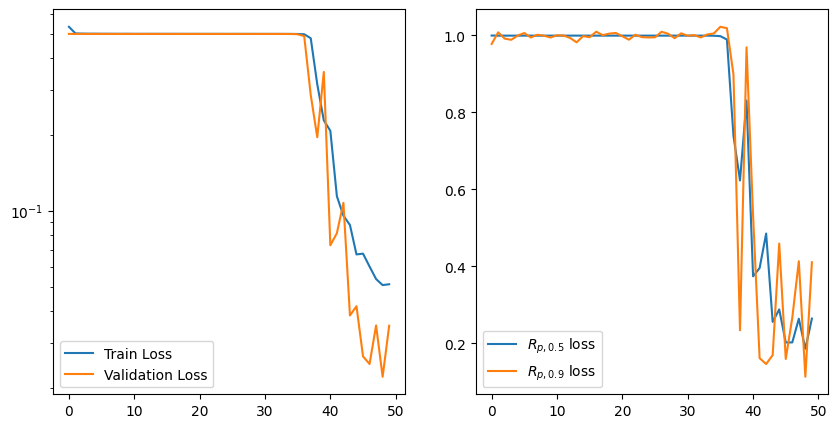

In [216]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_yscale('log')
ax1.plot(train_history, label="Train Loss")
ax1.plot(val_history, label="Validation Loss")
ax1.legend()

ax2.plot(R_ps, label=["$R_{p, 0.5}$ loss", "$R_{p, 0.9}$ loss"])
ax2.legend()

#### Testing model

In [217]:
test_loss, r_ps = val_step_enc_dec(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, r_ps

(0.032941212743520736, tensor([0.2525, 0.3837], device='cuda:0'))

#### Predict

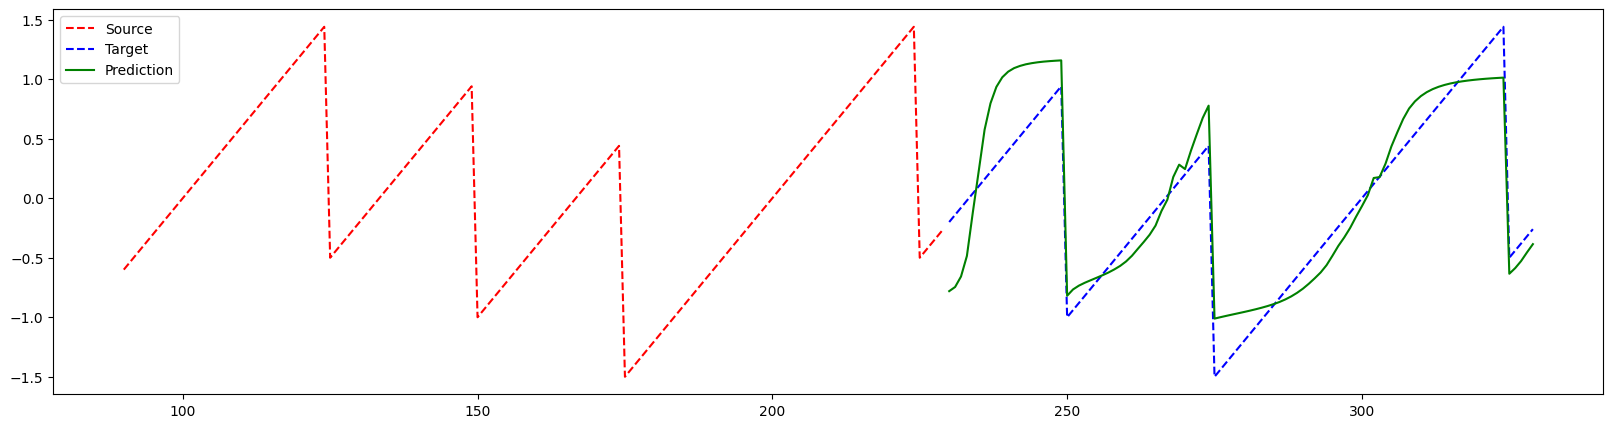

In [218]:
idx = 90
mask = dataset.mask
shift = dataset.shift

enc_attention_weights = []
dec_attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    # seq = torch.clone(tgt_fX)
    # seq[:, -shift-1:] = torch.zeros_like(seq[:, -shift-1:])
    
    out = model(src_X, src_fX, tgt_X, tgt_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    pred_X = tgt_X[:, -shift:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift:].squeeze().cpu()
    
    enc_attention_weights.append(model.enc_attn_weights)
    dec_attention_weights.append(model.dec_attn_weights)

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(pred_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X, pred_fX, '-g', label="Prediction")
# plt.plot(tgt_X.squeeze().cpu(), out.squeeze().cpu(), '-', label="Prediction")
plt.legend()

In [219]:
inspect_step = 0

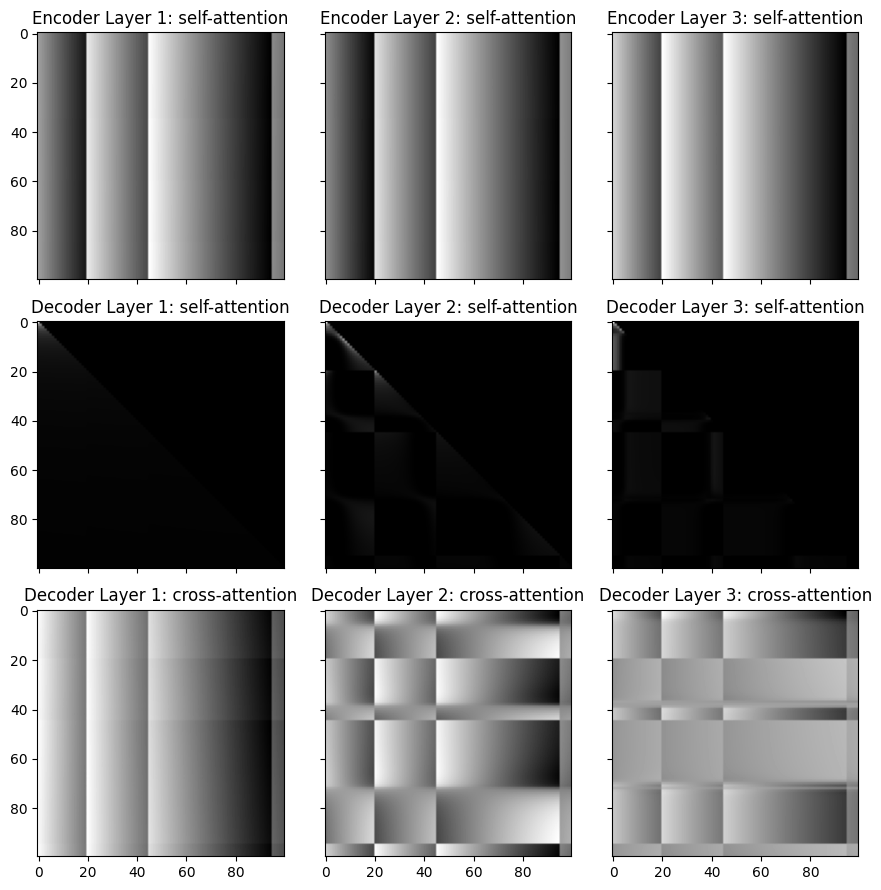

In [220]:
fig, axes = plt.subplots(3, n_layers, figsize=(3*n_layers, 9), sharex=True, sharey=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    ax.imshow(enc_attention_weights[inspect_step][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Encoder Layer {j+1}: self-attention")

for j, ax in enumerate(axes[1]):
    ax.imshow(dec_attention_weights[inspect_step][0][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: self-attention")
    
for j, ax in enumerate(axes[2]):
    ax.imshow(dec_attention_weights[inspect_step][1][j][0, 0, :, -shift:].cpu(), cmap='gray')
    ax.set_title(f"Decoder Layer {j+1}: cross-attention")

plt.tight_layout()

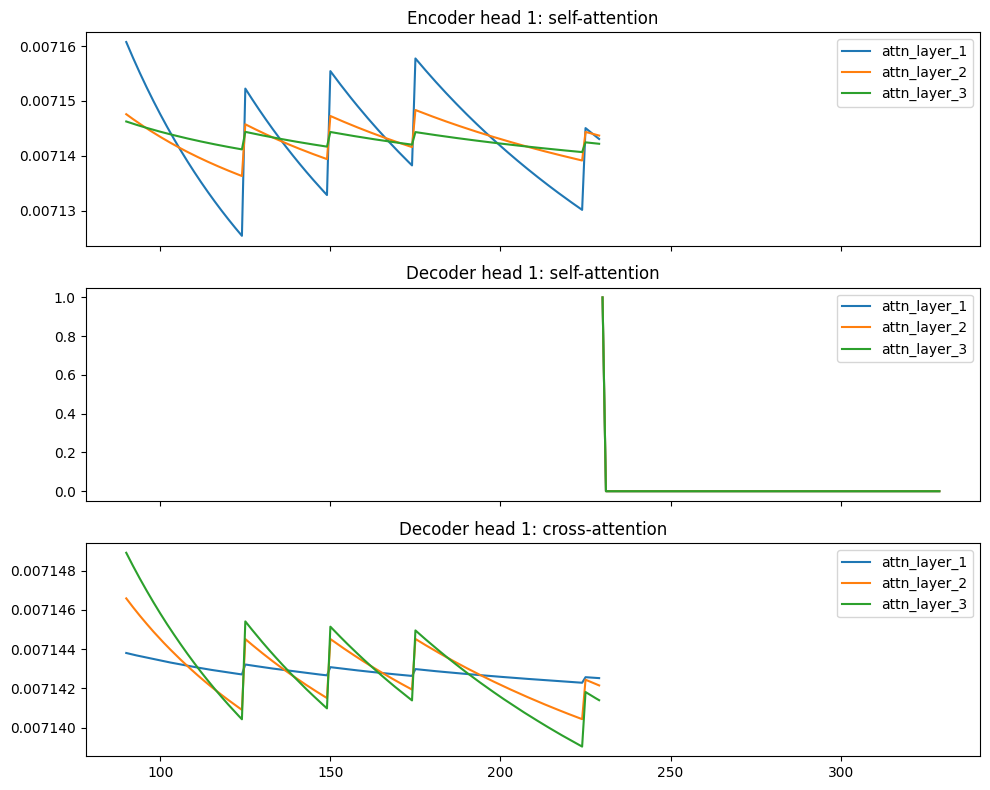

In [221]:
fig, axes = plt.subplots(3, n_heads, figsize=(10*n_heads, 8), sharex=True, squeeze=False)

for j, ax in enumerate(axes[0]):
    for i in range(n_layers):
        attn = enc_attention_weights[inspect_step][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Encoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[1]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][0][i][0, j, -shift, :].cpu()
        ax.plot(pred_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: self-attention")
    ax.legend()

for j, ax in enumerate(axes[2]):
    for i in range(n_layers):
        attn = dec_attention_weights[inspect_step][1][i][0, j, -shift, :].cpu()
        ax.plot(src_X.squeeze().cpu(), attn, label=f'attn_layer_{i+1}')
    ax.set_title(f"Decoder head {j+1}: cross-attention")
    ax.legend()

plt.tight_layout()

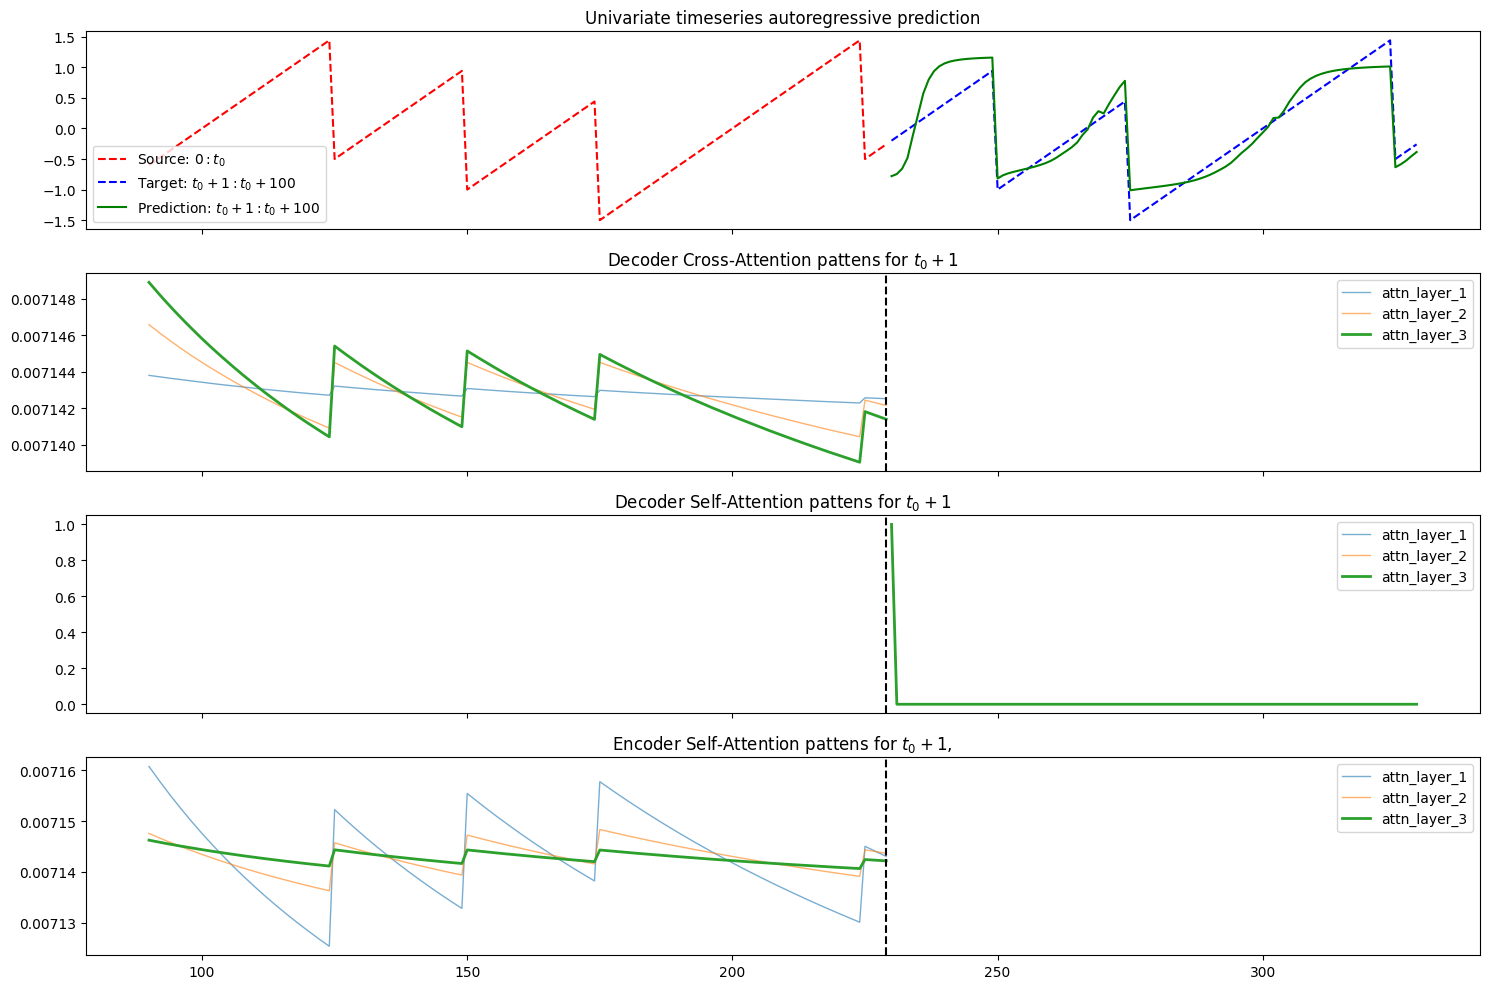

In [222]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(pred_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(pred_X.cpu(), pred_fX.cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.legend()
ax1.set_title(f"Univariate timeseries autoregressive prediction")

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][1][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Decoder Cross-Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

for i in range(n_layers):
    attn = dec_attention_weights[inspect_step][0][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax3.plot(pred_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax3.set_title(f"Decoder Self-Attention pattens for $t_0+{inspect_step+1}$")
ax3.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax3.legend()

for i in range(n_layers):
    attn = enc_attention_weights[inspect_step][i][0, 0, -shift, :].cpu()
    if i == n_layers-1:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax4.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax4.set_title(f"Encoder Self-Attention pattens for $t_0+{inspect_step+1}, $")
ax4.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax4.legend()

plt.tight_layout()
fig.savefig(f"../../img/baseline_enc_dec/sawtooth_multi_enc_dec_baseline_attn_{shift}pred_at_once_non_overlapping.pdf", dpi=1200)